# SPF : obtain the NutriScore of any given product

We were tasked, with a given dataset (https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip), to predict the NutriScore of any given food or drink.

To do this, we will:
- Establish what relevant categories will be used
- Clean and prepare the dataset

The final objective is to determine if it is possible to suggest or auto-fill the data for a given product.


**GDPR DISCLAIMER** \
The following work is not related to GDPR. To demonstrate, we will take all  major points and justify that our work is not concerned.


- **Only collect truly useful data to achieve objectives** \
Our working dataset does not contain any personnal data of any kind, only data related to food or drinks, which we need to work on NutriScore.
- **Be transparent** \
This code is for everyone to see, and sources are cited accordingly
- **Organize and ease people's rights usage** \
No personnal data is used, making this article irrelevant for the present work
- **Establish conservation duration** \
The dataset used will be used actively for a maximum of months, after which the current project should be finished. Dataset will then be archived.
- **Secure data and identify risks** \
This project is led locally, and as such has little to no risk of outside exposure. Moreover, containing no personnal data, an eventual malevolent action would only lead to a delay in the project, and no threat potential could be gained by such an action.
- **Compliance as a continuous process** \
Once this project is finished, it will be presented and then archived. As such, the dataset compliance will not be relevant anymore.

We hope that this convinced you that this project is not in any way linked to the GDPR rules. If not, we look forward to read you remarks at this email adress:\
kanamojo@hotmail.fr

Source: https://www.cnil.fr/fr/comprendre-le-rgpd/les-six-grands-principes-du-rgpd

### Librairies to be used

In [143]:
#DL libraries
import os
import urllib.request
import zipfile 

#Treatment libraries
import pandas as pd
import numpy as np
import scipy

# IterativeImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#data viz librairies
import matplotlib.pyplot as plt
import seaborn as sns

#PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


#ANVOA
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Downloading data

In [144]:
# URL of the file to be downloaded
url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/parcours-data-scientist/P2/fr.openfoodfacts.org.products.csv.zip'

# Directory where the file will be saved
directory = 'data'
if not os.path.exists(directory):
    os.makedirs(directory)
    print("directory 'data' created")

# Define the path for the downloaded file
zip_file_path = os.path.join(directory, 'downloaded_file.zip')

# Download the file

    # Check if the file already exists
if not os.path.isfile(zip_file_path):
    # Download the file
    try:
        print("Downloading the file...")
        urllib.request.urlretrieve(url, zip_file_path)
        print("File downloaded and saved as 'downloaded_file.zip' in the 'data' directory.")
    except Exception as e:
        print("An error occurred while downloading the file:", e)
else:
    print("The file already exists. No need to download again.")

The file already exists. No need to download again.


#### Extracting data

In [145]:
# Path to the downloaded zip file
zip_file_path = 'data/downloaded_file.zip'

# Extract the zip file
try:
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    print("Files extracted successfully.")
except zipfile.BadZipFile:
    print("Error: The file is not a zip file or it is corrupted.")
except Exception as e:
    print("An error occurred:", e)

Files extracted successfully.


#### Loading data

In [146]:
#Define csv path
csv_file_path = 'data/fr.openfoodfacts.org.products.csv'

#Load file
data = pd.read_csv(csv_file_path, sep='\t', low_memory=False)

## Etablir la faisabilité de suggérer les valeurs manquantes pour une variable dont plus de 50% des valeurs sont manquantes.

1- Repérer les variables pertinentes pour la prédictions et le remplissage des valeurs manquantes

2- Nettoyer les données en :

   - mettant en évidence les éventuelles valeurs manquantes parmi les variables pertinentes sélectionnées, avec au moins 3 méthodes de traitement adaptées aux variables concernées,
   - identifiant et en traitant les éventuelles valeurs aberrantes de chaque variable.


## Identify pertinent variables

#### Pertinent variables

Herre are the retained variables after domain-related researches : \
identification : "code","product_name", \
scoring : "nutrition_grade_fr","nutrition-score-fr_100g", \
description : "pnns_groups_1", "pnns_groups_2" \
nutritional value : "energy_100g", \
components : "fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g",
                   "proteins_100g","salt_100g","fiber_100g", "fruits-vegetables-nuts_100g"
                  

In [147]:
columns_to_keep = ["code","product_name",
                   "nutrition-score-fr_100g","nutrition_grade_fr",
                   "pnns_groups_1", "pnns_groups_2",
                   "energy_100g", 
                   "fat_100g", "saturated-fat_100g","sugars_100g",
                   "proteins_100g","salt_100g","fiber_100g",
                  "carbohydrates_100g","fruits-vegetables-nuts_100g"]

In [148]:
#Assessing missing values in columns kept
for col in columns_to_keep:
    t = data[col].isna().value_counts(normalize=True)
    miss = t.get(True)*100
    print(miss, f'% of {col} is missing')
    if miss >= 50:
        print(f'{col} must be dropped !')

0.007170201887945333 % of code is missing
5.537266344942825 % of product_name is missing
31.038245233374482 % of nutrition-score-fr_100g is missing
31.038245233374482 % of nutrition_grade_fr is missing
71.47101367949821 % of pnns_groups_1 is missing
pnns_groups_1 must be dropped !
70.54262840896337 % of pnns_groups_2 is missing
pnns_groups_2 must be dropped !
18.598568453605676 % of energy_100g is missing
23.967490928135874 % of fat_100g is missing
28.437020687591186 % of saturated-fat_100g is missing
23.630803187310615 % of sugars_100g is missing
18.969860212237975 % of proteins_100g is missing
20.345291983090792 % of salt_100g is missing
37.374209719052786 % of fiber_100g is missing
24.06195054431185 % of carbohydrates_100g is missing
99.05353335079121 % of fruits-vegetables-nuts_100g is missing
fruits-vegetables-nuts_100g must be dropped !


In [149]:
#checking if nans can be infered form grade to score 

#gathering indexes
i = data["nutrition_grade_fr"].isna()
j = data["nutrition-score-fr_100g"].isna()
x = data[i].index
y = data[j].index

#comparison
set(x)==set(y)

#returns True => missing values have the same index,meaning they can't be infered from one another

True

As one cannot be deduced from the other, we will drop rows where "nutrition-score-fr_100g" are empty

In [150]:
#Since we want to predict nutrition grade and score, we will drop lines where those are empty
#Dropping lines where considered column is empty
data.dropna(axis=0, subset="nutrition-score-fr_100g", inplace=True)
data

code                                                url  \
1       0000000004530  http://world-fr.openfoodfacts.org/produit/0000...   
2       0000000004559  http://world-fr.openfoodfacts.org/produit/0000...   
3       0000000016087  http://world-fr.openfoodfacts.org/produit/0000...   
7       0000000016124  http://world-fr.openfoodfacts.org/produit/0000...   
12      0000000016872  http://world-fr.openfoodfacts.org/produit/0000...   
...               ...                                                ...   
320742  9787461062105  http://world-fr.openfoodfacts.org/produit/9787...   
320751  9847548283004  http://world-fr.openfoodfacts.org/produit/9847...   
320757  9900000000233  http://world-fr.openfoodfacts.org/produit/9900...   
320763       99111250  http://world-fr.openfoodfacts.org/produit/9911...   
320768       99567453  http://world-fr.openfoodfacts.org/produit/9956...   

                creator   created_t      created_datetime last_modified_t  \
1       usda-ndb-import  1489069957  2017-03-09T14:32:37Z      1489069957   
2       usda-ndb-import  1489069957  2017-03-09T14:32:37Z      1489069957   
3       usda-ndb-import  1489055731  2017-03-09T10:35:31Z      1489055731   
7       usda-ndb-import  1489055711  2017-03-09T10:35:11Z      1489055712   
12      usda-ndb-import  1489055650  2017-03-09T10:34:10Z      1489055651   
...                 ...         ...                   ...             ...   
320742  usda-ndb-import  1489092300  2017-03-09T20:45:00Z      1489092300   
320751        drmalabar  1437817626  2015-07-25T09:47:06Z      1442237848   
320757          kiliweb  1491079938  2017-04-01T20:52:18Z      1491079939   
320763         balooval  1367163039  2013-04-28T15:30:39Z      1371690556   
320768  usda-ndb-import  1489059076  2017-03-09T11:31:16Z      1491244499   

       last_modified_datetime  \
1        2017-03-09T14:32:37Z   
2        2017-03-09T14:32:37Z   
3        2017-03-09T10:35:31Z   
7        2017-03-09T10:35:12Z   
12       2017-03-09T10:34:11Z   
...                       ...   
320742   2017-03-09T20:45:00Z   
320751   2015-09-14T13:37:28Z   
320757   2017-04-01T20:52:19Z   
320763   2013-06-20T01:09:16Z   
320768   2017-04-03T18:34:59Z   

                                             product_name       generic_name  \
1                          Banana Chips Sweetened (Whole)                NaN   
2                                                 Peanuts                NaN   
3                                  Organic Salted Nut Mix                NaN   
7                                          Organic Muesli                NaN   
12                                          Zen Party Mix                NaN   
...                                                   ...                ...   
320742                                    Natural Cassava                NaN   
320751                Tartines craquantes bio au sarrasin                NaN   
320757                                            Amandes                NaN   
320763                                 Thé vert Earl grey  thé bio équitable   
320768  Mint Melange Tea A Blend Of Peppermint, Lemon ...                NaN   

       quantity  ... ph_100g fruits-vegetables-nuts_100g  \
1           NaN  ...     NaN                         NaN   
2           NaN  ...     NaN                         NaN   
3           NaN  ...     NaN                         NaN   
7           NaN  ...     NaN                         NaN   
12          NaN  ...     NaN                         NaN   
...         ...  ...     ...                         ...   
320742      NaN  ...     NaN                         NaN   
320751      NaN  ...     NaN                         NaN   
320757      NaN  ...     NaN                         NaN   
320763     50 g  ...     NaN                         NaN   
320768      NaN  ...     NaN                         NaN   

       collagen-meat-protein-ratio_100g cocoa_100g chlorophyl_100g  \
1                             

In [151]:
#Dropping all columns not considered relevant for the application
relevant_data = data.drop(columns=[col for col in data.columns if col not in columns_to_keep])
relevant_data

code                                       product_name  \
1       0000000004530                     Banana Chips Sweetened (Whole)   
2       0000000004559                                            Peanuts   
3       0000000016087                             Organic Salted Nut Mix   
7       0000000016124                                     Organic Muesli   
12      0000000016872                                      Zen Party Mix   
...               ...                                                ...   
320742  9787461062105                                    Natural Cassava   
320751  9847548283004                Tartines craquantes bio au sarrasin   
320757  9900000000233                                            Amandes   
320763       99111250                                 Thé vert Earl grey   
320768       99567453  Mint Melange Tea A Blend Of Peppermint, Lemon ...   

       nutrition_grade_fr         pnns_groups_1          pnns_groups_2  \
1                       d                   NaN                    NaN   
2                       b                   NaN                    NaN   
3                       d                   NaN                    NaN   
7                       c                   NaN                    NaN   
12                      d                   NaN                    NaN   
...                   ...                   ...                    ...   
320742                  a                   NaN                    NaN   
320751                  a  Cereals and potatoes                  Bread   
320757                  b                   NaN                    NaN   
320763                  c             Beverages  Non-sugared beverages   
320768                  b                   NaN                    NaN   

        energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
1            2243.0     28.57               28.57               64.29   
2            1941.0     17.86                0.00               60.71   
3            2540.0     57.14                5.36               17.86   
7            1833.0     18.75                4.69               57.81   
12           2230.0     36.67                5.00               36.67   
...             ...       ...                 ...                 ...   
320742       1477.0      0.00                0.00               87.06   
320751       1643.0      2.80                0.60               74.80   
320757       2406.0       NaN                3.73                 NaN   
320763         21.0      0.20                0.20                0.50   
320768          0.0      0.00                0.00                0.00   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  \
1             14.29         3.6           3.57    0.00000   
2             17.86         7.1          17.86    0.63500   
3              3.57         7.1          17.86    1.22428   
7             15.62         9.4          14.06    0.13970   
12             3.33         6.7          16.67    1.60782   
...             ...         ...            ...        ...   
320742         2.35         4.7           1.18    0.03048   
320751         2.60         5.9          13.00    0.68000   
320757         3.89        12.2          21.22    0.10000   
320763         0.50         0.2           0.50    0.02540   
320768         0.00         0.0           0.00    0.00000   

        fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
1                               NaN                     14.0  
2                               NaN                      0.0  
3                               NaN                     12.0  
7                               NaN                      7.0  
12                              NaN                     12.0  
...                             ...                      ...  
320742                          NaN                     -1.0  
320751                          NaN                     -4.0  
320757                          NaN   

We will wirte a function that returns a list of columns to be dropped according to a certain threshold

In [152]:
#Prepare a function to do a list of columns to be deleted 
def define_delete(dataframe, threshold = 50):
    to_delete = []
    for col in dataframe:
      miss_norm = dataframe[col].isna().value_counts(normalize=True)
      if True in miss_norm.index:
        miss_percent = round(miss_norm.get(True, 0)*100,5)
        if miss_percent > threshold:
          to_delete.append(col)
    return to_delete

In [153]:
delete_list = define_delete(data[columns_to_keep], 50)
print(delete_list)

['pnns_groups_1', 'pnns_groups_2', 'fruits-vegetables-nuts_100g']


In [154]:
#Drop columns accordingly
#raw_data = data.drop(columns=delete_list)
#raw_data.head()

This automated approach would deprive us of pnns groups descriptive. We will not proceed with this in order \
to conserve information, however incomplete

## Numerical data treatment 
- Removal of duplicates
- Values above 100 and under 0 set to NaN
- Max energy value

In [155]:
#looks like there are no duplicates
relevant_data["code"].duplicated().sum()

0

In [156]:
# Eliminating duplicates
relevant_data = relevant_data.drop_duplicates(subset="code", keep=False)
relevant_data

code                                       product_name  \
1       0000000004530                     Banana Chips Sweetened (Whole)   
2       0000000004559                                            Peanuts   
3       0000000016087                             Organic Salted Nut Mix   
7       0000000016124                                     Organic Muesli   
12      0000000016872                                      Zen Party Mix   
...               ...                                                ...   
320742  9787461062105                                    Natural Cassava   
320751  9847548283004                Tartines craquantes bio au sarrasin   
320757  9900000000233                                            Amandes   
320763       99111250                                 Thé vert Earl grey   
320768       99567453  Mint Melange Tea A Blend Of Peppermint, Lemon ...   

       nutrition_grade_fr         pnns_groups_1          pnns_groups_2  \
1                       d                   NaN                    NaN   
2                       b                   NaN                    NaN   
3                       d                   NaN                    NaN   
7                       c                   NaN                    NaN   
12                      d                   NaN                    NaN   
...                   ...                   ...                    ...   
320742                  a                   NaN                    NaN   
320751                  a  Cereals and potatoes                  Bread   
320757                  b                   NaN                    NaN   
320763                  c             Beverages  Non-sugared beverages   
320768                  b                   NaN                    NaN   

        energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
1            2243.0     28.57               28.57               64.29   
2            1941.0     17.86                0.00               60.71   
3            2540.0     57.14                5.36               17.86   
7            1833.0     18.75                4.69               57.81   
12           2230.0     36.67                5.00               36.67   
...             ...       ...                 ...                 ...   
320742       1477.0      0.00                0.00               87.06   
320751       1643.0      2.80                0.60               74.80   
320757       2406.0       NaN                3.73                 NaN   
320763         21.0      0.20                0.20                0.50   
320768          0.0      0.00                0.00                0.00   

        sugars_100g  fiber_100g  proteins_100g  salt_100g  \
1             14.29         3.6           3.57    0.00000   
2             17.86         7.1          17.86    0.63500   
3              3.57         7.1          17.86    1.22428   
7             15.62         9.4          14.06    0.13970   
12             3.33         6.7          16.67    1.60782   
...             ...         ...            ...        ...   
320742         2.35         4.7           1.18    0.03048   
320751         2.60         5.9          13.00    0.68000   
320757         3.89        12.2          21.22    0.10000   
320763         0.50         0.2           0.50    0.02540   
320768         0.00         0.0           0.00    0.00000   

        fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
1                               NaN                     14.0  
2                               NaN                      0.0  
3                               NaN                     12.0  
7                               NaN                      7.0  
12                              NaN                     12.0  
...                             ...                      ...  
320742                          NaN                     -1.0  
320751                          NaN                     -4.0  
320757                          NaN   

### Treating values superior to 100g or inferior to 0g

In [157]:
# Categorizing columns to clean them up 
components_100g = ["fat_100g","saturated-fat_100g","carbohydrates_100g","sugars_100g",
                   "proteins_100g","salt_100g","fiber_100g", "fruits-vegetables-nuts_100g"]

In [158]:
# Define a functions that sets all aberrant values to NaN
def set_aberrant_to_nan(value):
    if value > 100 or value < 0:
        return np.nan
    else: 
        return value

In [159]:
#Apply treatment to each column
for col in components_100g:
    relevant_data[col] = relevant_data[col].map(set_aberrant_to_nan)

In [160]:
relevant_data[relevant_data.columns].describe()

energy_100g       fat_100g  saturated-fat_100g  carbohydrates_100g  \
count  2.210190e+05  203729.000000       221017.000000       203695.000000   
mean   1.196345e+03      13.360915            4.966724           33.223316   
std    6.989607e+03      16.111217            7.559124           28.310324   
min    0.000000e+00       0.000000            0.000000            0.000000   
25%    4.520000e+02       0.880000            0.000000            7.000000   
50%    1.195000e+03       7.140000            1.790000           24.000000   
75%    1.716000e+03      21.430000            7.140000           59.000000   
max    3.251373e+06     100.000000          100.000000          100.000000   

         sugars_100g     fiber_100g  proteins_100g      salt_100g  \
count  221005.000000  193768.000000  221017.000000  220967.000000   
mean       15.005555       2.800207       7.774046       1.236260   
std        19.818932       4.477916       8.074198       3.942034   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.300000       0.000000       1.900000       0.100000   
50%         5.000000       1.500000       5.700000       0.647700   
75%        23.080000       3.600000      10.710000       1.361440   
max       100.000000     100.000000     100.000000     100.000000   

       fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
count                  2817.000000            221210.000000  
mean                     30.078442                 9.165535  
std                      32.082987                 9.055903  
min                       0.000000               -15.000000  
25%                       0.000000                 1.000000  
50%                      17.000000                10.000000  
75%                      50.000000                16.000000  
max                     100.000000                40.000000

### Max energy value 


The Max energy value is 3765600j = 3765.6kj = 900kcal \
We don't know what the standard is for "energy_100g" \ 
We need to ask to manager of the dataset to settle this \

In the mean time, we will consider the kj number as the limit, for 2 reasons : \
- The average value of "energy_100g" is 1141.91, which is superior to the kcal max. It is unlikely therefore that this be the scale, otherwise the majority of the column would be erroneous \
- In the dataset description, a energy-kcal_100g and energy-kj_100g are presented, even if they cannot be found in the dataset. However, no energy-j_100g is presented. \

We conclude that the scale used for energy 100g is kj, until confirmation of dataset's manager.

In [161]:
# Define max value
max_energy_value=3765.6

In [162]:
# Checking => checked => commented for documentation
# relevant_data[relevant_data["energy_100g"]>max_energy_value]

In [163]:
# Setting values over max value to nan
relevant_data.loc[relevant_data["energy_100g"]>max_energy_value, "energy_100g"] = np.nan

## Categorical data treatment
- Inspection of categories
- Redundacies treamtent if needed

In [164]:
categories = ["pnns_groups_1", "pnns_groups_2"]

In [165]:
# Quick glance at categories
for col in categories:
    print(col, '\n', relevant_data[col].unique())
    print(relevant_data[col].nunique(),"unique values", '\n')

pnns_groups_1 
 [nan 'unknown' 'Fruits and vegetables' 'Sugary snacks' 'Composite foods'
 'Beverages' 'Fish Meat Eggs' 'Fat and sauces' 'Cereals and potatoes'
 'Milk and dairy products' 'Salty snacks' 'fruits-and-vegetables'
 'sugary-snacks' 'cereals-and-potatoes' 'salty-snacks']
14 unique values 

pnns_groups_2 
 [nan 'unknown' 'Vegetables' 'Biscuits and cakes' 'Pizza pies and quiche'
 'Sweets' 'Sweetened beverages' 'One-dish meals' 'Soups' 'Meat'
 'Dressings and sauces' 'Cereals' 'Fruits' 'Milk and yogurt' 'Fats'
 'Non-sugared beverages' 'Cheese' 'Chocolate products' 'Sandwich' 'Bread'
 'Nuts' 'Legumes' 'Breakfast cereals' 'Appetizers' 'Fruit juices' 'Eggs'
 'Fish and seafood' 'Dried fruits' 'Ice cream' 'Processed meat'
 'vegetables' 'pastries' 'Dairy desserts' 'Alcoholic beverages' 'Potatoes'
 'Artificially sweetened beverages' 'Fruit nectars' 'fruits'
 'Salty and fatty products' 'Tripe dishes' 'cereals' 'legumes' 'nuts']
42 unique values 



Some categories are duplicated with a bad spelling ("sugary-snacks" and "Sugary snacks" for example) \
We need to clean this up

In [166]:
#normalizing the names of categories
for col in categories:
    relevant_data[col] = relevant_data[col].str.lower().str.replace('-', ' ')

In [167]:
# Quick check at categories after cleaning
for col in categories:
    print(col, '\n', relevant_data[col].unique())
    print(relevant_data[col].nunique(),"unique values", '\n')

pnns_groups_1 
 [nan 'unknown' 'fruits and vegetables' 'sugary snacks' 'composite foods'
 'beverages' 'fish meat eggs' 'fat and sauces' 'cereals and potatoes'
 'milk and dairy products' 'salty snacks']
10 unique values 

pnns_groups_2 
 [nan 'unknown' 'vegetables' 'biscuits and cakes' 'pizza pies and quiche'
 'sweets' 'sweetened beverages' 'one dish meals' 'soups' 'meat'
 'dressings and sauces' 'cereals' 'fruits' 'milk and yogurt' 'fats'
 'non sugared beverages' 'cheese' 'chocolate products' 'sandwich' 'bread'
 'nuts' 'legumes' 'breakfast cereals' 'appetizers' 'fruit juices' 'eggs'
 'fish and seafood' 'dried fruits' 'ice cream' 'processed meat' 'pastries'
 'dairy desserts' 'alcoholic beverages' 'potatoes'
 'artificially sweetened beverages' 'fruit nectars'
 'salty and fatty products' 'tripe dishes']
37 unique values 



We will also fill any nans with the value 'others'. \
We note the existence of a "unknown" category, which we won't use, to remain able distinguish data marked as unknown and nans

In [168]:
for col in categories:
    relevant_data.loc[relevant_data[col].isna(), col] = relevant_data[col].fillna('others')

In [169]:
for col in categories:
    print(relevant_data[col].isna().value_counts())

False    221210
Name: pnns_groups_1, dtype: int64
False    221210
Name: pnns_groups_2, dtype: int64


## Filling missing values
Only numerical values can be filled, as categorical values cannot be infered \
(though maybe with a ML algorythm that maps through all components once encoded with HotOneEncoder for example ?) 

- Impute correlated numerical values with IterativeImputer
- Impute numerical value with mean
- Impute numerical value with median

In [170]:
# Observe missing values per components
relevant_data[components_100g].isna().sum()

fat_100g                        17481
saturated-fat_100g                193
carbohydrates_100g              17515
sugars_100g                       205
proteins_100g                     193
salt_100g                         243
fiber_100g                      27442
fruits-vegetables-nuts_100g    218393
dtype: int64

In [171]:
# Observe missing values per components

for col in components_100g:
    print(relevant_data[col].isna().value_counts())

False    203729
True      17481
Name: fat_100g, dtype: int64
False    221017
True        193
Name: saturated-fat_100g, dtype: int64
False    203695
True      17515
Name: carbohydrates_100g, dtype: int64
False    221005
True        205
Name: sugars_100g, dtype: int64
False    221017
True        193
Name: proteins_100g, dtype: int64
False    220967
True        243
Name: salt_100g, dtype: int64
False    193768
True      27442
Name: fiber_100g, dtype: int64
True     218393
False      2817
Name: fruits-vegetables-nuts_100g, dtype: int64


### Iterative Imputer

We first need to evaluate variables correlation before going into imputation

We will use variables correlated for 64% to encompass nutrition score

In [172]:
#First define a dataframe holding all numerical features, not just components
numeric_values = relevant_data.select_dtypes(include=["int64", "float64"])

Text(0.5, 1.0, 'Correlation Map of categories')

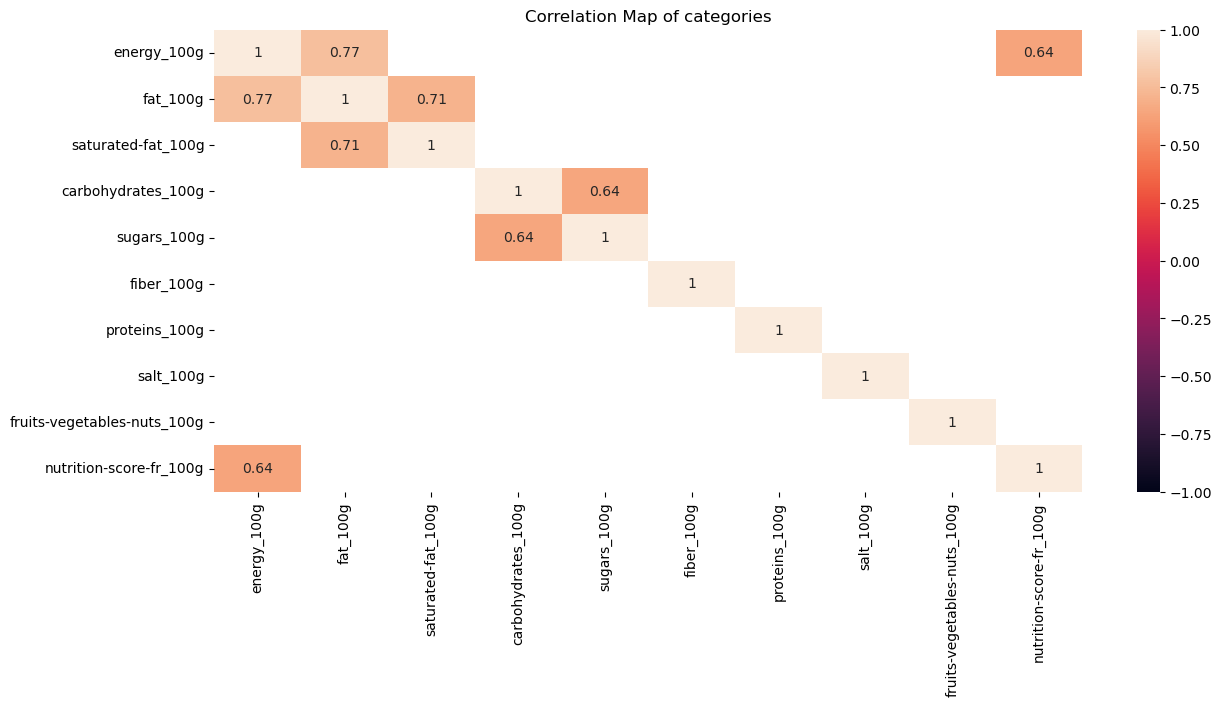

In [173]:
#Preparing the correlation map
corrmap = numeric_values.corr()
#Defining the threshold for correaltion
mask = np.abs(corrmap) <= 0.635

#Displaying only values above or equal to threshold
plt.figure(figsize=(14, 6))
sns.heatmap(corrmap, mask=mask, vmin=-1, vmax=1, annot=True).set_title("Correlation Map of categories")

Now that we have our correlated variables, we can use an iterative imputer to fill them

In [174]:
# preparing a specific rule for energy_100g
pair1 = ['energy_100g', 'fat_100g']
imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0, max_value=3765.6)
# Select only the columns in the pair for imputation
df_pair = relevant_data[pair1]
# Apply imputation
df_imputed = imputer.fit_transform(df_pair)
# Update the original DataFrame with the imputed values
relevant_data[pair1] = df_imputed

In [175]:
# Define the correlated pairs
# Excluding the "energy_100g" out of the imputed values, as it has a max value of 3765.6 instead of 100
correlated_pairs = [
   # ['energy_100g', 'fat_100g'],
    ['fat_100g', 'saturated-fat_100g'],
    ['carbohydrates_100g', 'sugars_100g'],
    ['energy_100g', 'nutrition-score-fr_100g'],
]

# Apply IterativeImputer to each pair
for pair in correlated_pairs:
    imputer = IterativeImputer(max_iter=10, random_state=0, min_value=0, max_value=100)
    # Select only the columns in the pair for imputation
    df_pair = relevant_data[pair]
    # Apply imputation
    df_imputed = imputer.fit_transform(df_pair)
    # Update the original DataFrame with the imputed values
    relevant_data[pair] = df_imputed


#checking if all correlated variables have been filled
for col in numeric_values:
    print(relevant_data[col].isna().value_counts())

False    221210
Name: energy_100g, dtype: int64
False    221210
Name: fat_100g, dtype: int64
False    221210
Name: saturated-fat_100g, dtype: int64
False    221210
Name: carbohydrates_100g, dtype: int64
False    221210
Name: sugars_100g, dtype: int64
False    193768
True      27442
Name: fiber_100g, dtype: int64
False    221017
True        193
Name: proteins_100g, dtype: int64
False    220967
True        243
Name: salt_100g, dtype: int64
True     218393
False      2817
Name: fruits-vegetables-nuts_100g, dtype: int64
False    221210
Name: nutrition-score-fr_100g, dtype: int64


### Mean Imputation

Imputation by mean if and only if categorie does not have too many outliers \
We will check the following categories : 
 - proteins_100g
 - salt_100g
 - fiber_100g
 - fruits-vegetables-nuts_100g
 
 as the others have been filled by iterative imputer

#### Outliers detection 
To allow an empty value to be filled by the mean, we need to examine the serie. \
If said serie has with many outliers, it can't be filled by the mean.

In [176]:
remaining_components = ["proteins_100g", "salt_100g", "fiber_100g", "fruits-vegetables-nuts_100g"]

for col in remaining_components:
    print(relevant_data[col].describe())

count    221017.000000
mean          7.774046
std           8.074198
min           0.000000
25%           1.900000
50%           5.700000
75%          10.710000
max         100.000000
Name: proteins_100g, dtype: float64
count    220967.000000
mean          1.236260
std           3.942034
min           0.000000
25%           0.100000
50%           0.647700
75%           1.361440
max         100.000000
Name: salt_100g, dtype: float64
count    193768.000000
mean          2.800207
std           4.477916
min           0.000000
25%           0.000000
50%           1.500000
75%           3.600000
max         100.000000
Name: fiber_100g, dtype: float64
count    2817.000000
mean       30.078442
std        32.082987
min         0.000000
25%         0.000000
50%        17.000000
75%        50.000000
max       100.000000
Name: fruits-vegetables-nuts_100g, dtype: float64


In [177]:
# using the zscore to determine how unstable the series are

for col in remaining_components:
    x = scipy.stats.zscore(relevant_data[col], axis=None,nan_policy="omit")
    y = x.where(x>abs(1.5)).value_counts().sum()
    z = x.value_counts().sum()
    print(round((y/z)*100, 2), f"% of {col} are outliers")

10.01 % of proteins_100g are outliers
1.47 % of salt_100g are outliers
6.28 % of fiber_100g are outliers
11.0 % of fruits-vegetables-nuts_100g are outliers


The categorie "salt_100g" is the less filled with outliers, and so its mean is less sensitive. \
We can afford to fill it by the mean value. 

#### Filling categories without too many outliers with mean value

In [178]:
# Calculate the median of the current column for salt_100g
mean_salt = relevant_data.groupby('pnns_groups_2')["salt_100g"].transform('mean')

# Fill missing values in the current column with the median of their respective category
relevant_data.loc[relevant_data["salt_100g"].isna(), "salt_100g"] = mean_salt[relevant_data["salt_100g"].isna()]


In [179]:
for col in remaining_components:
    print(relevant_data[col].isna().value_counts())

False    221017
True        193
Name: proteins_100g, dtype: int64
False    221210
Name: salt_100g, dtype: int64
False    193768
True      27442
Name: fiber_100g, dtype: int64
True     218393
False      2817
Name: fruits-vegetables-nuts_100g, dtype: int64


In [180]:
# now that "salt_100g" has been filled, we can drop it out of the list 
if "salt_100g" in remaining_components:
    remaining_components.remove("salt_100g")

### Median imputation
Median imputation will be performed on individuals of the same category, which is to say of the same pnns_group

We will work with the pnns_group_2, as this group has more unique values, we think results will be more accurate

In [181]:
#checking for all components
for col in remaining_components:
    print(relevant_data[col].isna().value_counts())

False    221017
True        193
Name: proteins_100g, dtype: int64
False    193768
True      27442
Name: fiber_100g, dtype: int64
True     218393
False      2817
Name: fruits-vegetables-nuts_100g, dtype: int64


In [182]:
for column in remaining_components:
    # Calculate the median of the current column for each category
    median_per_category = relevant_data.groupby('pnns_groups_2')[column].transform('median')

    # Fill missing values in the current column with the median of their respective category
    relevant_data.loc[relevant_data[column].isna(), column] = median_per_category[relevant_data[column].isna()]

# Display the DataFrame to verify the changes
for col in remaining_components:
    print(relevant_data[col].isna().value_counts())

False    221210
Name: proteins_100g, dtype: int64
False    221210
Name: fiber_100g, dtype: int64
True     159453
False     61757
Name: fruits-vegetables-nuts_100g, dtype: int64


Only "fruits-vegetables-nuts_100g" remains. Will now try with "pnns_group_1"

In [183]:
relevant_data["fruits-vegetables-nuts_100g"] = relevant_data.groupby('pnns_groups_1')[col].transform(
    lambda x: x.fillna(x.median()))

In [184]:
relevant_data["fruits-vegetables-nuts_100g"].isna().value_counts()

False    221210
Name: fruits-vegetables-nuts_100g, dtype: int64

In [185]:
relevant_data.head()

code                    product_name nutrition_grade_fr  \
1   0000000004530  Banana Chips Sweetened (Whole)                  d   
2   0000000004559                         Peanuts                  b   
3   0000000016087          Organic Salted Nut Mix                  d   
7   0000000016124                  Organic Muesli                  c   
12  0000000016872                   Zen Party Mix                  d   

   pnns_groups_1 pnns_groups_2  energy_100g  fat_100g  saturated-fat_100g  \
1         others        others       2243.0     28.57               28.57   
2         others        others       1941.0     17.86                0.00   
3         others        others       2540.0     57.14                5.36   
7         others        others       1833.0     18.75                4.69   
12        others        others       2230.0     36.67                5.00   

    carbohydrates_100g  sugars_100g  fiber_100g  proteins_100g  salt_100g  \
1                64.29        14.29         3.6           3.57    0.00000   
2                60.71        17.86         7.1          17.86    0.63500   
3                17.86         3.57         7.1          17.86    1.22428   
7                57.81        15.62         9.4          14.06    0.13970   
12               36.67         3.33         6.7          16.67    1.60782   

    fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
1                          25.0                     14.0  
2                          25.0                      0.0  
3                          25.0                     12.0  
7                          25.0                      7.0  
12                         25.0                     12.0

Our missing values have been filled, using 3 separate methods to smooth out risks of errors \
We will now proceed to statistical examination of our "new" dataset

In [186]:
completed_data = relevant_data.copy()

## Statistics analysis

### Univariate analysis

#### Numerical features

In [187]:
completed_data["energy_100g"].describe()

count    221210.000000
mean       1175.334771
std         758.381804
min           0.000000
25%         452.000000
50%        1188.000000
75%        1712.975000
max        3765.600000
Name: energy_100g, dtype: float64

In [188]:
summary_stats = completed_data.describe()
summary_stats[components_100g]

fat_100g  saturated-fat_100g  carbohydrates_100g    sugars_100g  \
count  221210.000000       221210.000000       221210.000000  221210.000000   
mean       13.355644            4.966702           33.200061      15.005330   
std        15.807510            7.555826           27.662979      19.809845   
min         0.000000            0.000000            0.000000       0.000000   
25%         0.880000            0.000000            7.960000       1.300000   
50%         7.526990            1.790000           24.000000       5.000000   
75%        21.430000            7.140000           57.690000      23.027500   
max       100.000000          100.000000          100.000000     100.000000   

       proteins_100g      salt_100g     fiber_100g  \
count  221210.000000  221210.000000  221210.000000   
mean        7.771282       1.236239       2.628671   
std         8.071876       3.939945       4.240774   
min         0.000000       0.000000       0.000000   
25%         1.900000       0.100000       0.000000   
50%         5.700000       0.650000       1.400000   
75%        10.710000       1.361440       3.500000   
max       100.000000     100.000000     100.000000   

       fruits-vegetables-nuts_100g  
count                221210.000000  
mean                     23.245351  
std                      15.737166  
min                       0.000000  
25%                      25.000000  
50%                      25.000000  
75%                      25.000000  
max                     100.000000

<AxesSubplot:xlabel='energy_100g', ylabel='Count'>

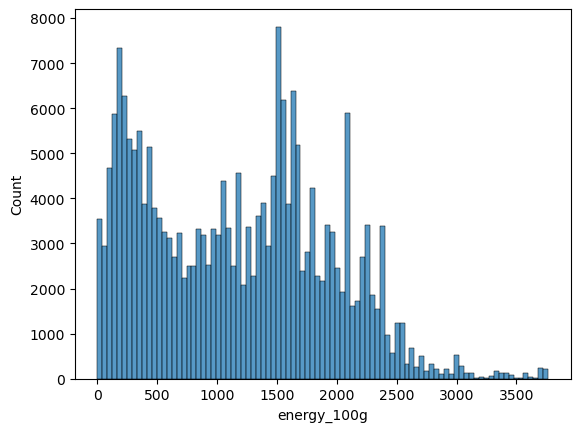

In [189]:
#plot energy 100g
sns.histplot(completed_data["energy_100g"])

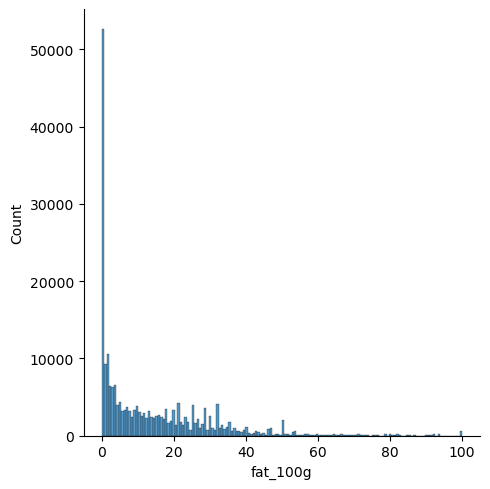

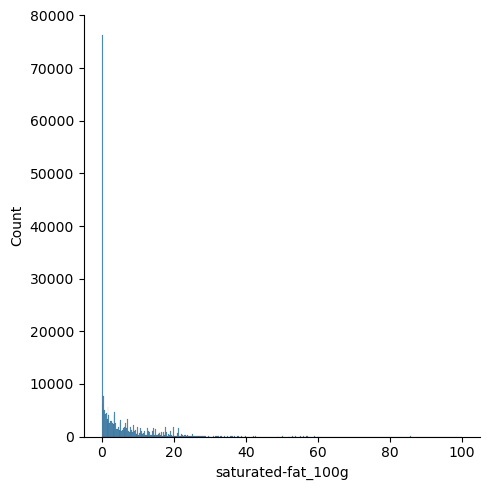

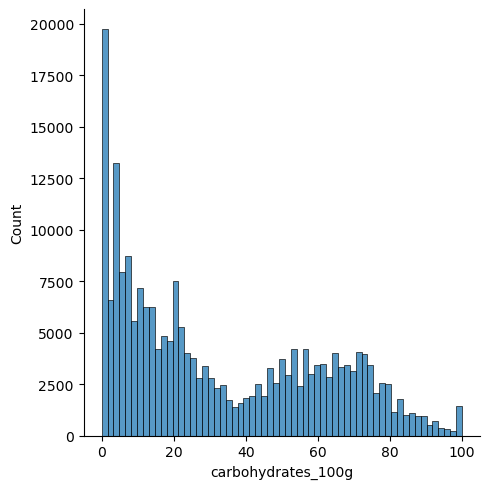

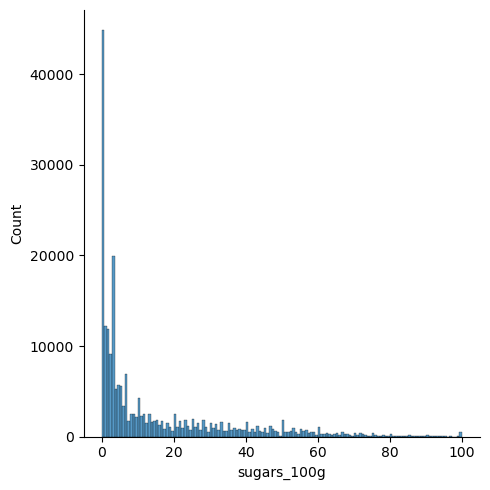

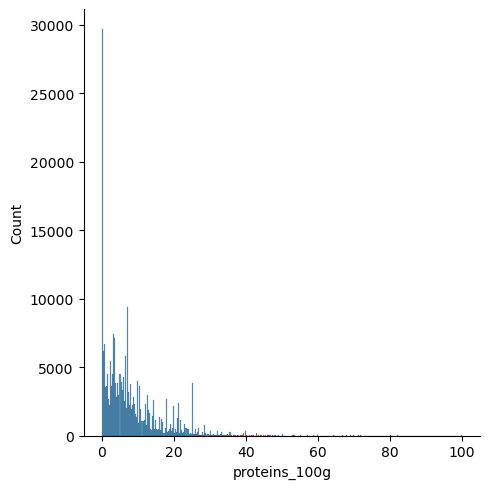

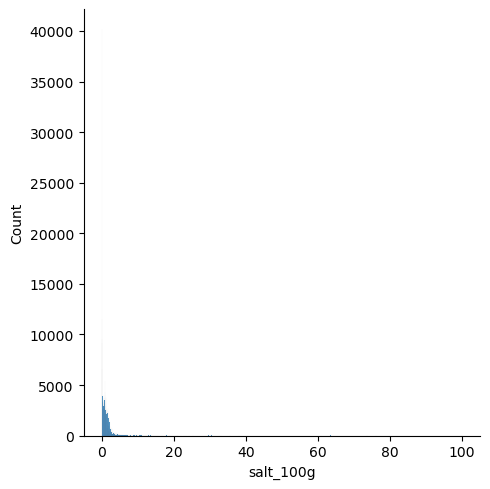

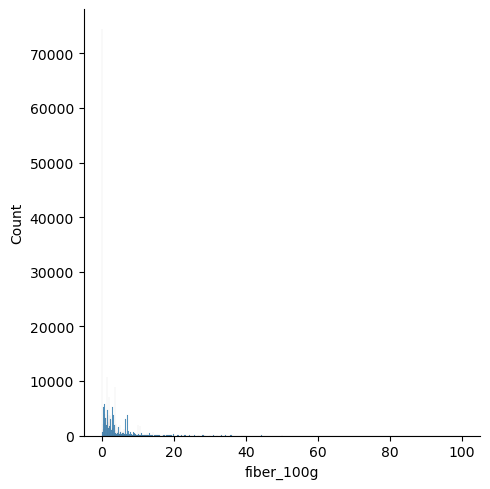

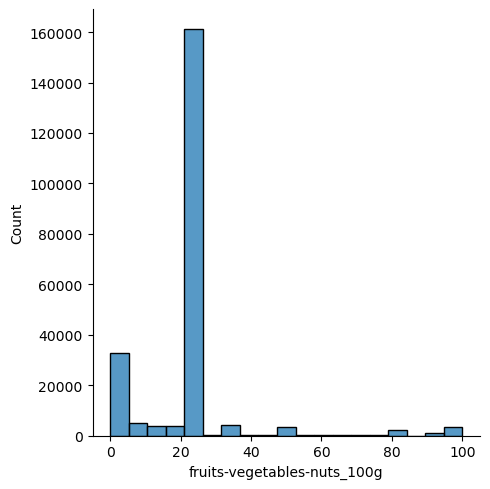

In [190]:
for col in components_100g:    
    sns.displot(completed_data[col])

L'imputation des variables semble avoir un impact visuellement très marquant, notamment pour la dernière feature, qui a été remplie à 98% de valeurs imputées.


#### Categorical features

##### Nominative categories

In [191]:
nominatives = ["pnns_groups_1", "pnns_groups_2"]

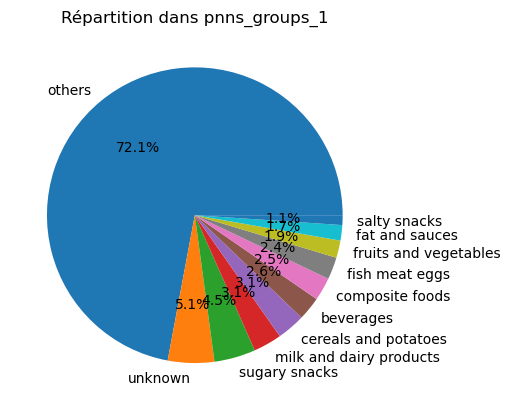

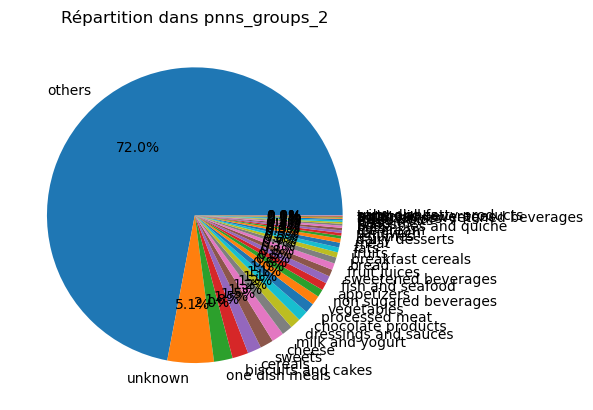

In [192]:
for col in nominatives:
    repartition = completed_data[col].value_counts()
    plt.pie(repartition, labels=repartition.index, autopct='%1.1f%%')
    plt.title(f"Répartition dans {col}")
    plt.show()

With the 'others' categorie replacing the nans, pie charts are unreadable \
A barplot would do a better job, and we will also remove the 'others' category, which is over-represented

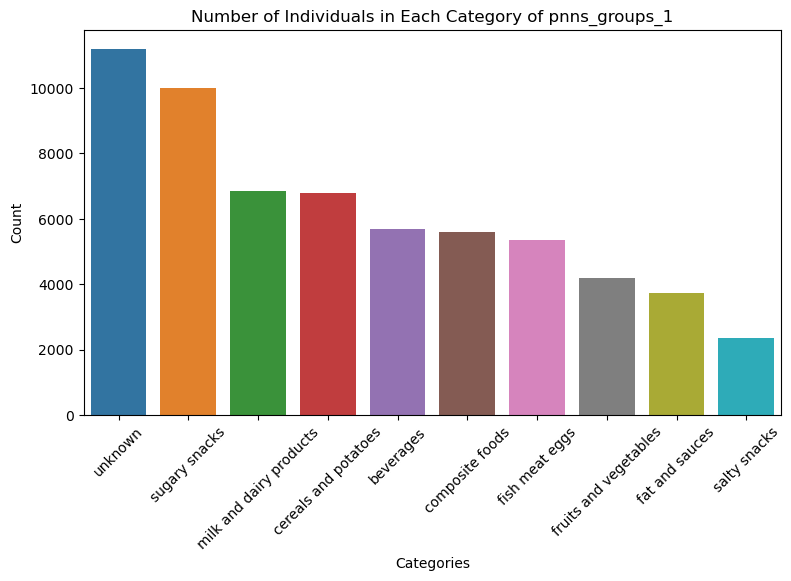

In [193]:
#groups1 without others
filtered_df = completed_data[completed_data['pnns_groups_1'] != 'others']

plt.figure(figsize=(9, 5)) 
sns.countplot(data=filtered_df, x="pnns_groups_1", order = filtered_df['pnns_groups_1'].value_counts().index)
plt.xticks(rotation=45)  
plt.title('Number of Individuals in Each Category of pnns_groups_1')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

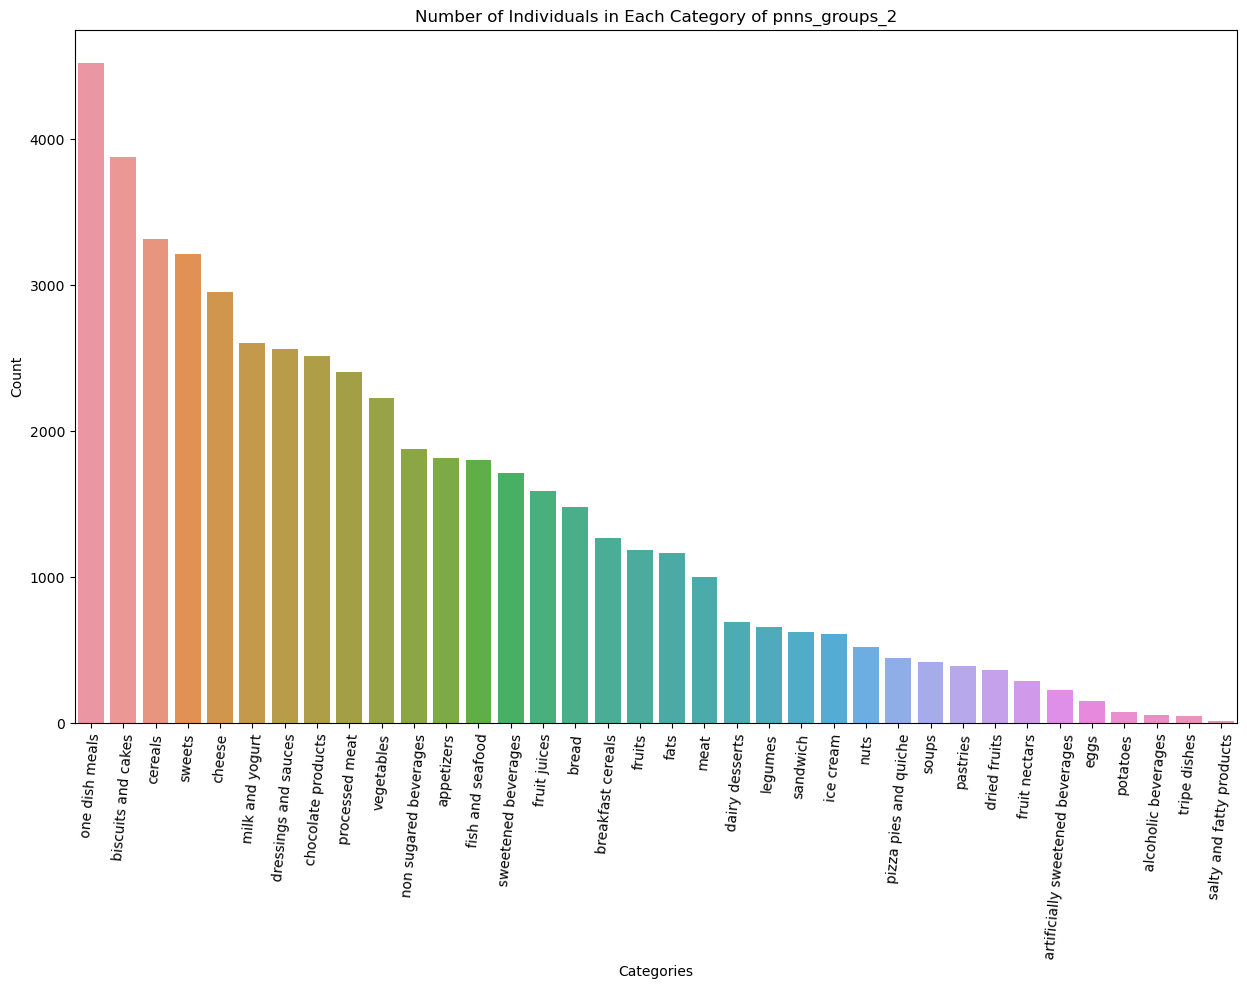

In [194]:
#groups2 without other nor unknown
filtered_df = completed_data[~completed_data['pnns_groups_2'].isin(['others', 'unknown'])]


plt.figure(figsize=(15, 9))  # Adjust the size of the plot as needed
sns.countplot(data=filtered_df, x="pnns_groups_2", order = filtered_df['pnns_groups_2'].value_counts().index)
plt.xticks(rotation=85)  # Rotate the labels for better readability
plt.title('Number of Individuals in Each Category of pnns_groups_2')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

##### Ordinal categories

In [195]:
ordinal = ["nutrition_grade_fr"]

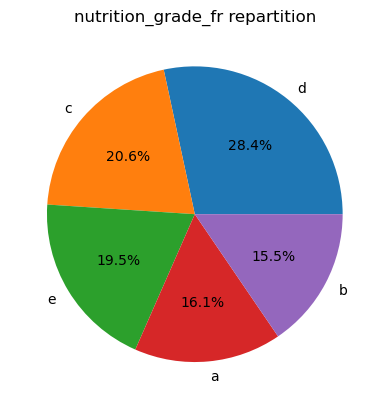

In [196]:
repartition = completed_data["nutrition_grade_fr"].value_counts()
plt.pie(repartition, labels=repartition.index, autopct='%1.1f%%')
plt.title(f"nutrition_grade_fr repartition")
plt.show()

Category 'd' is slightly over-represented, while 'b' is the least represented

### Bivariate analysis

#### Components relation between themselves - numerical to numercial

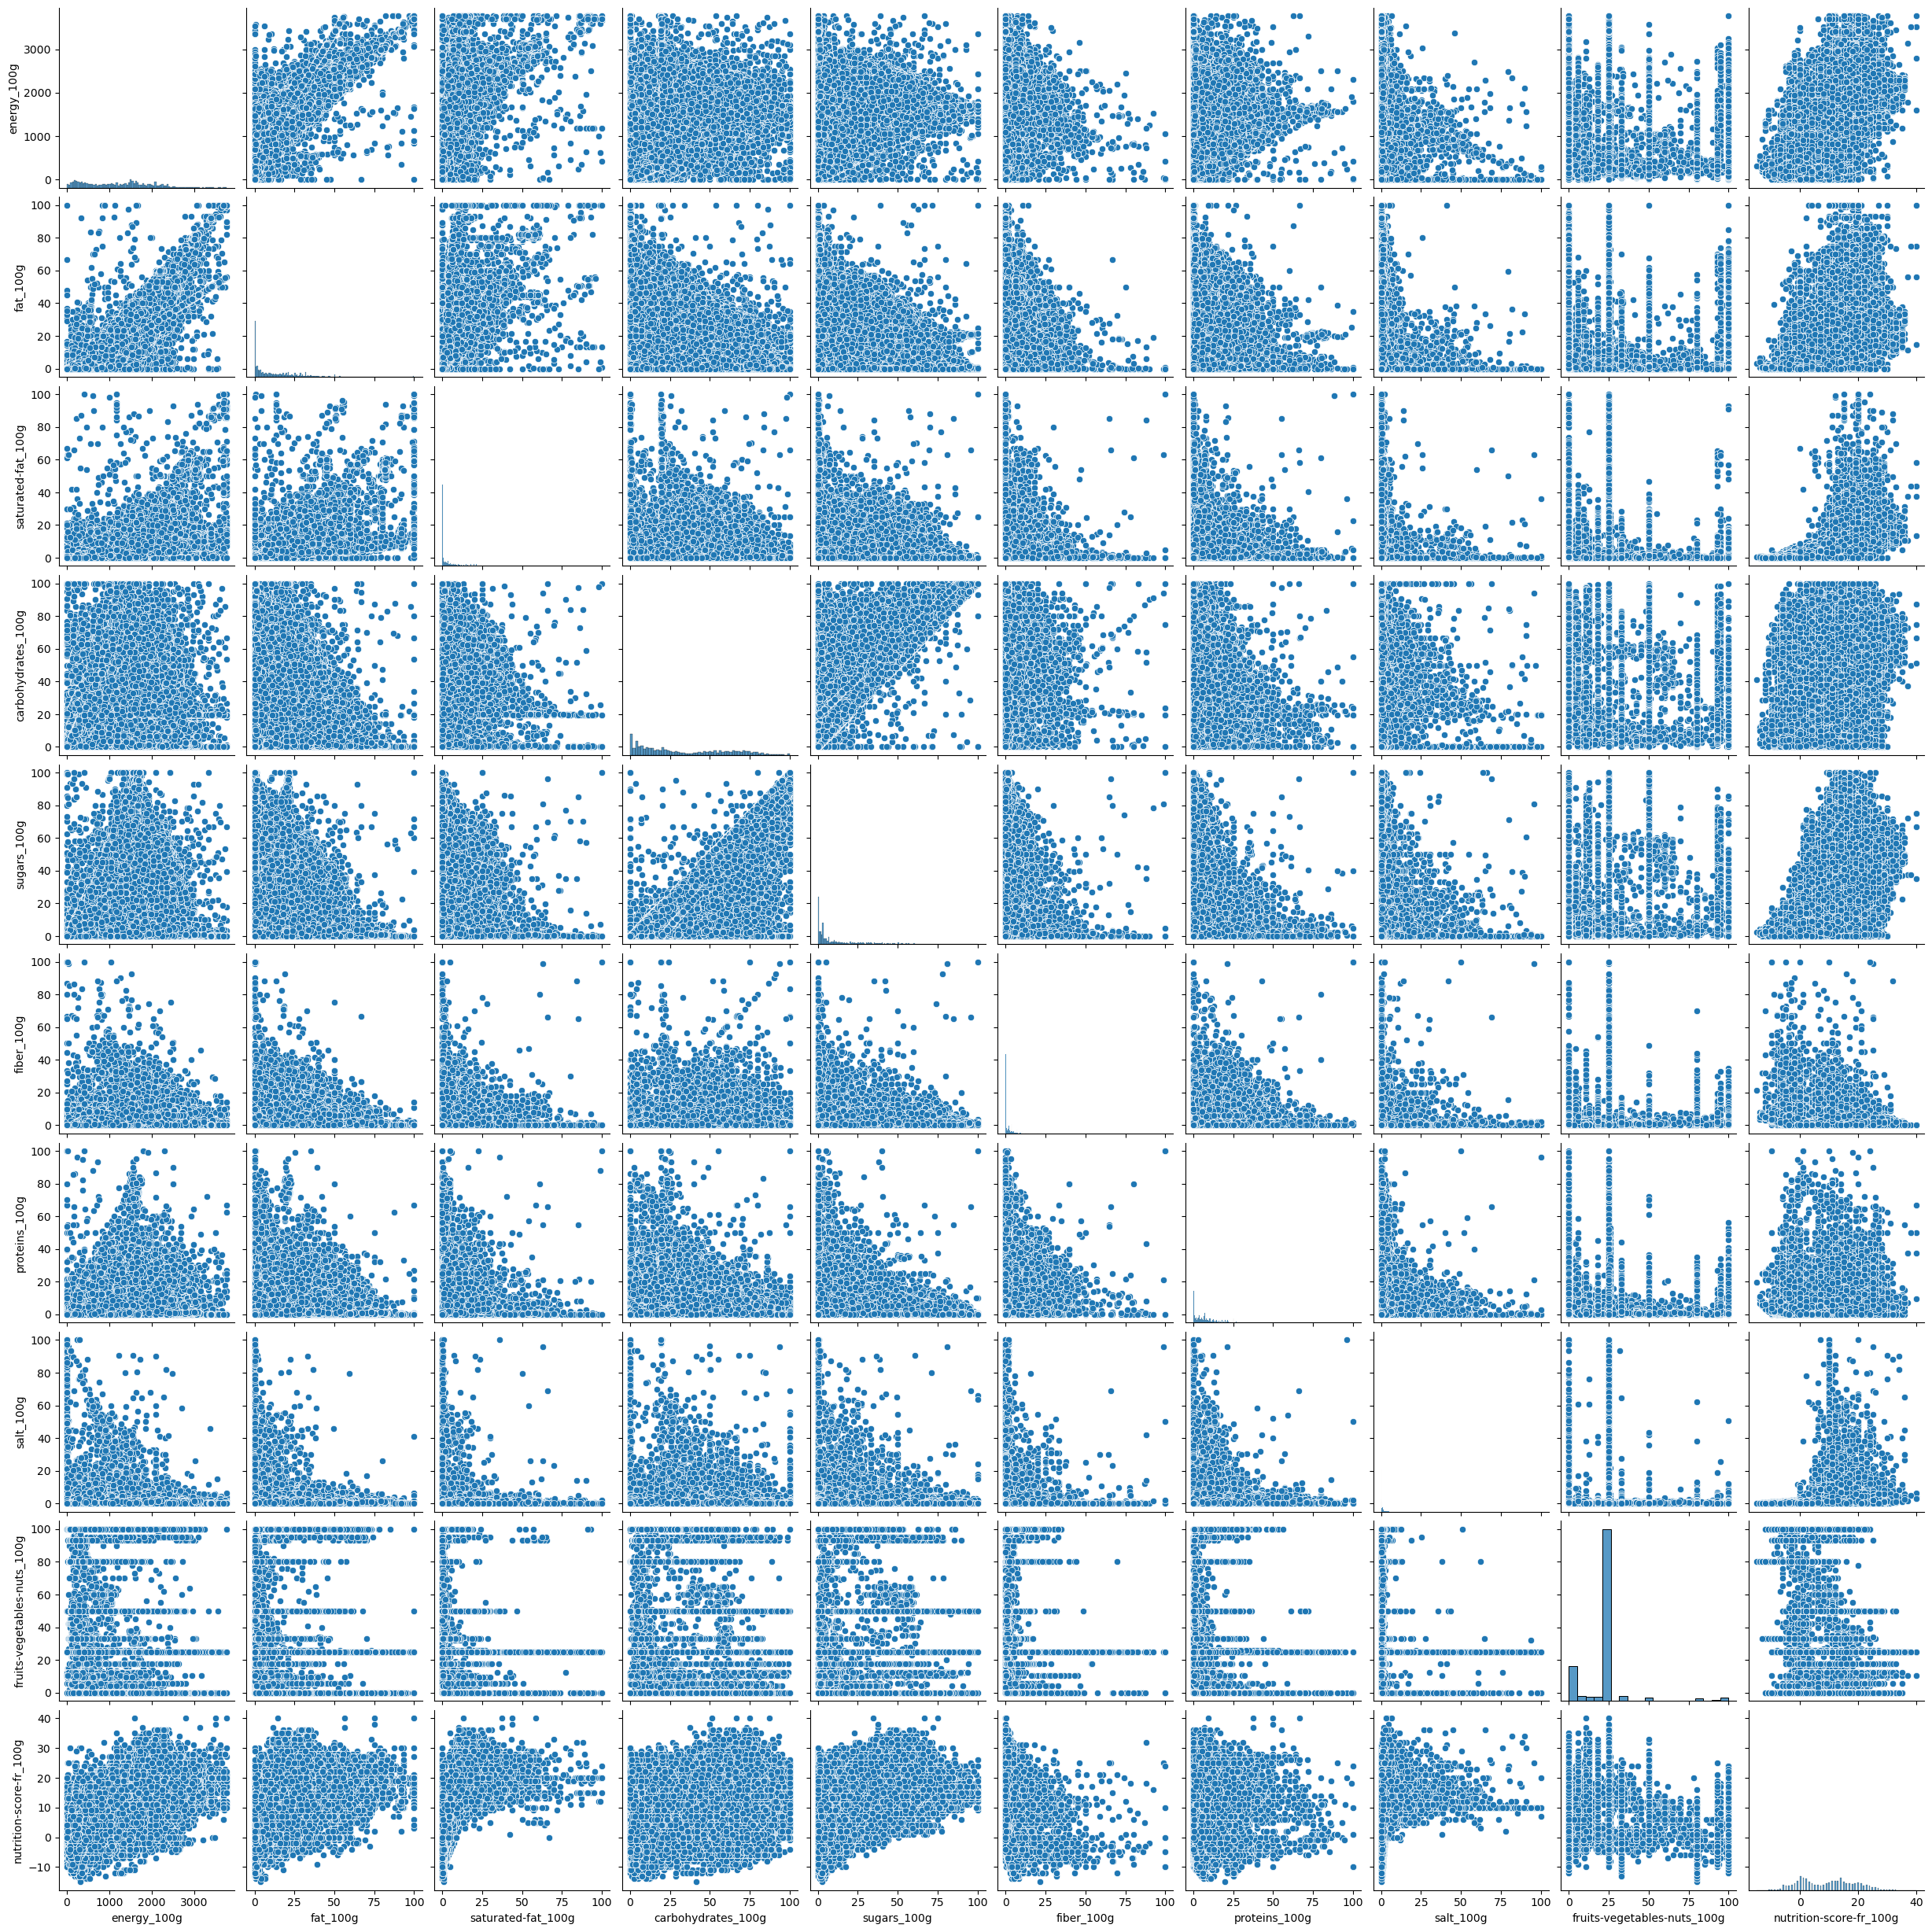

In [197]:
sns.pairplot(completed_data)

Text(0.5, 1.0, 'Correlation Map of categories')

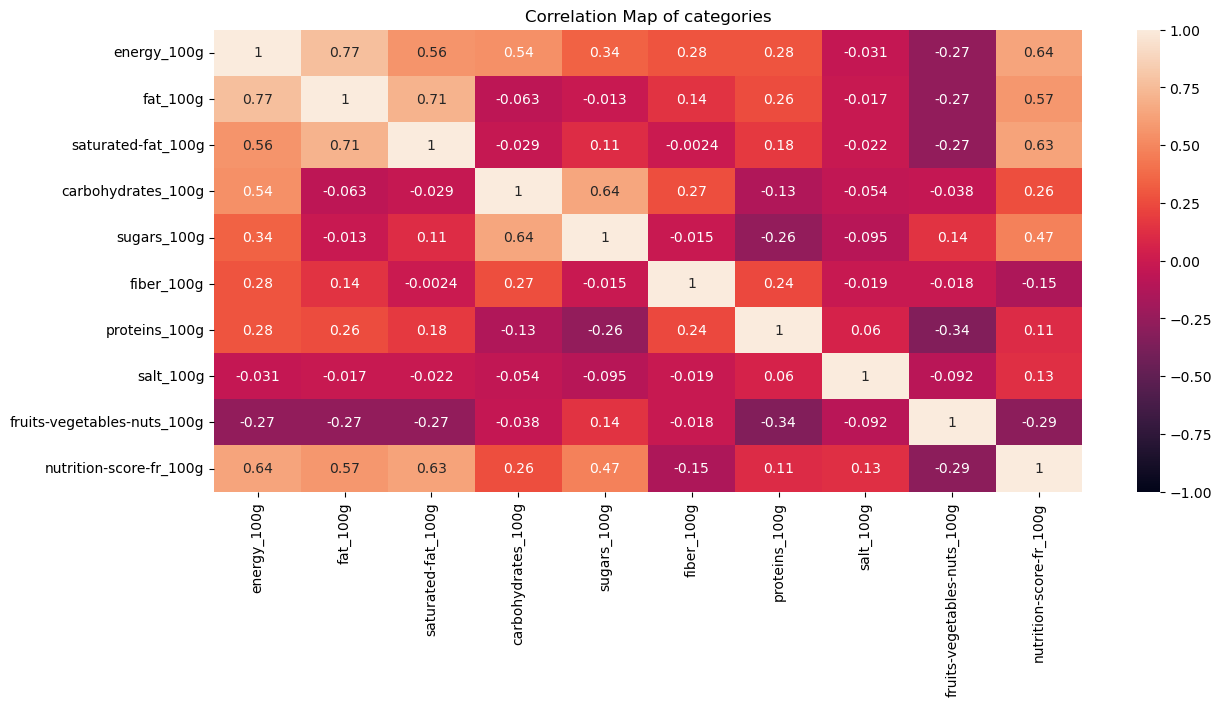

In [198]:
#Preparing the correlation map, reusing the numeric_values df
corrmap = numeric_values.corr()

#Displaying 
plt.figure(figsize=(14, 6))
sns.heatmap(corrmap, vmin=-1, vmax=1, annot=True).set_title("Correlation Map of categories")

#### Components relations to NutriScore - numerical to categorical ordinal

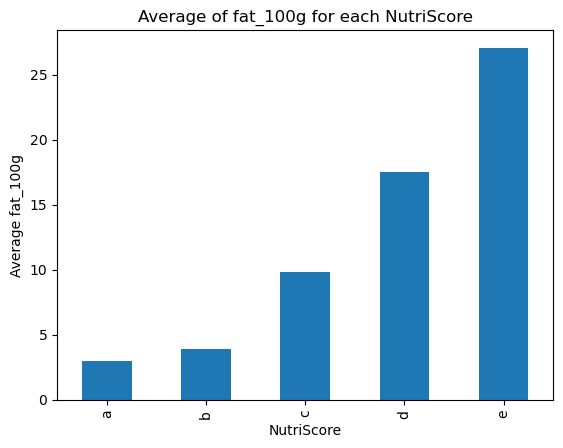

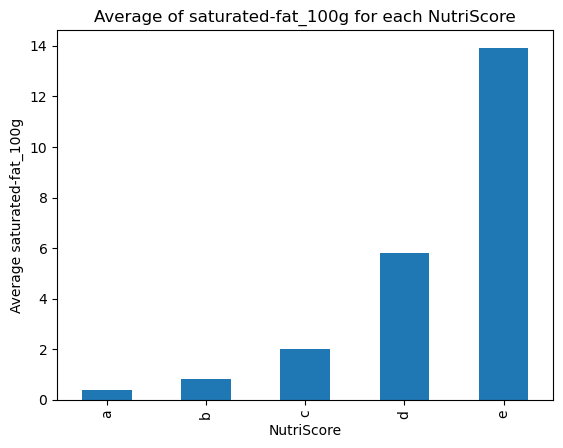

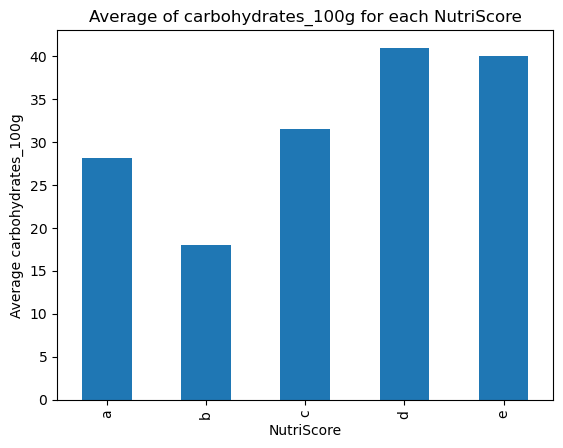

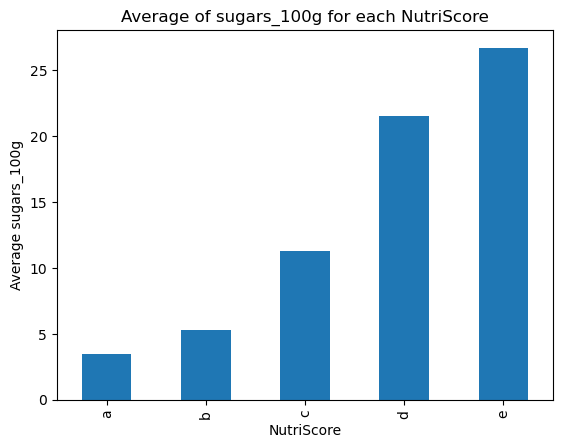

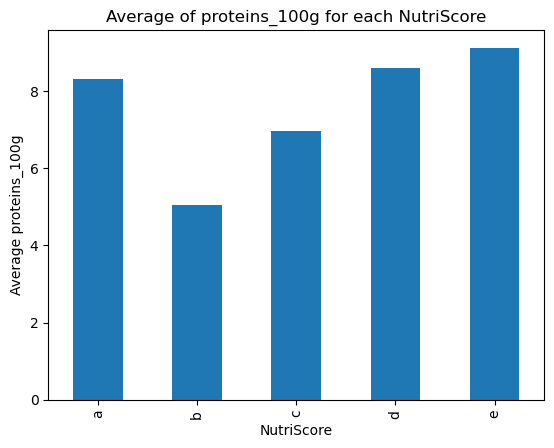

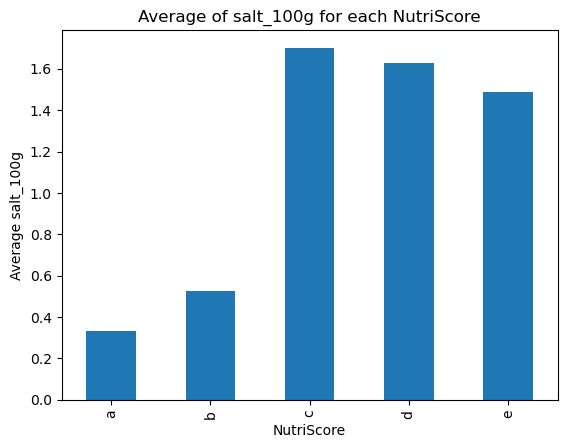

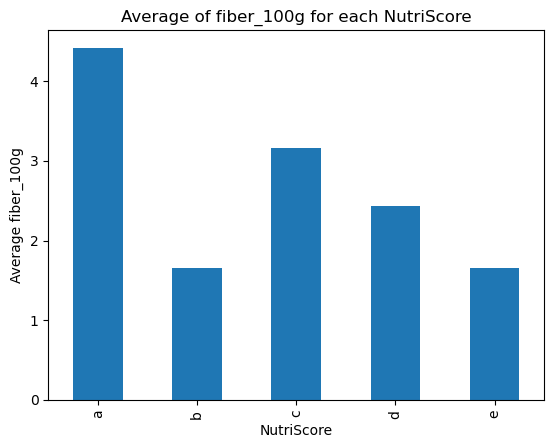

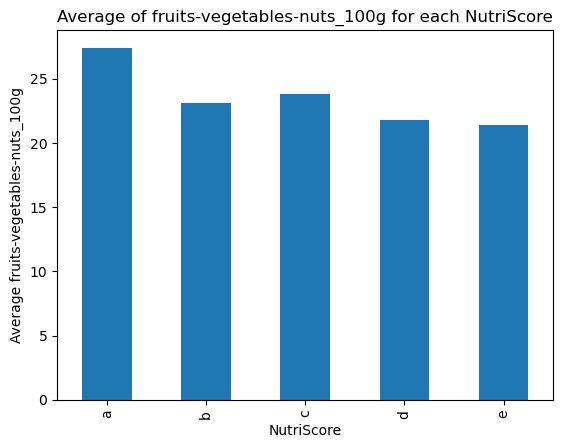

In [199]:
# Group by nutriscore
grouped_data = completed_data.groupby("nutrition_grade_fr")

# bar plotting for readability
for col in components_100g:
    grouped_data[col].mean().plot(kind='bar')
    plt.title(f'Average of {col} for each NutriScore')
    plt.xlabel('NutriScore')
    plt.ylabel(f'Average {col}')
    plt.show()

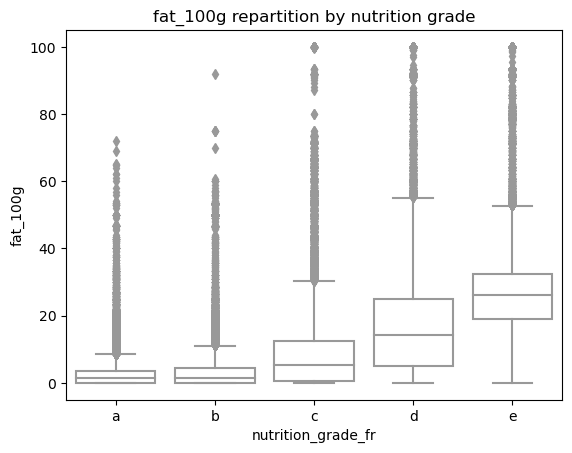

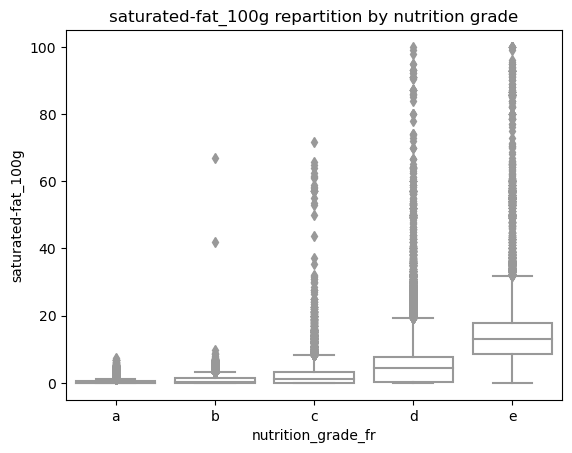

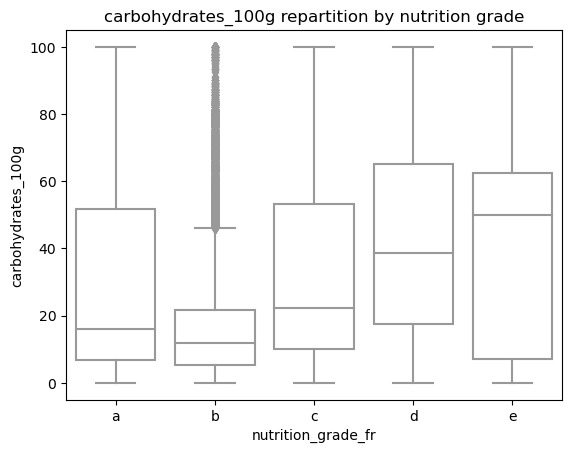

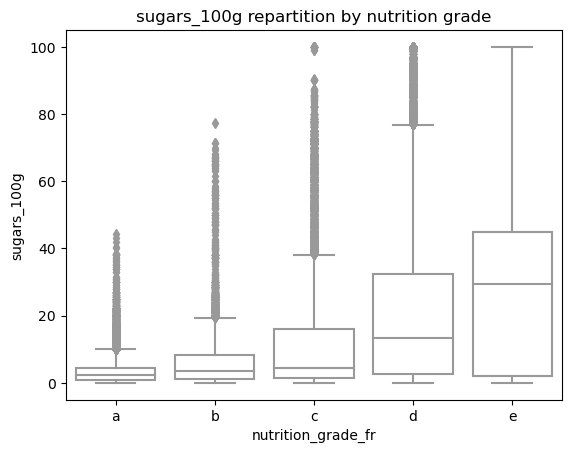

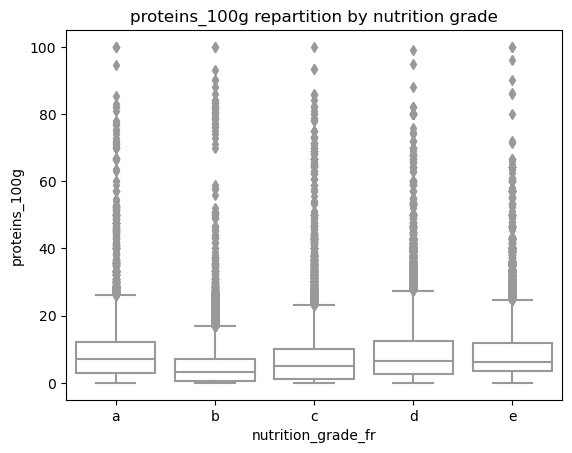

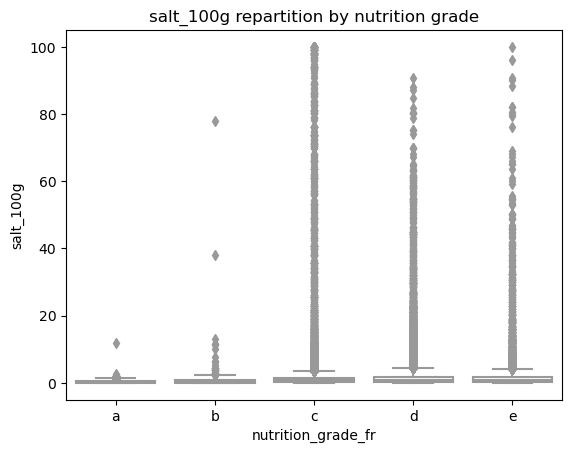

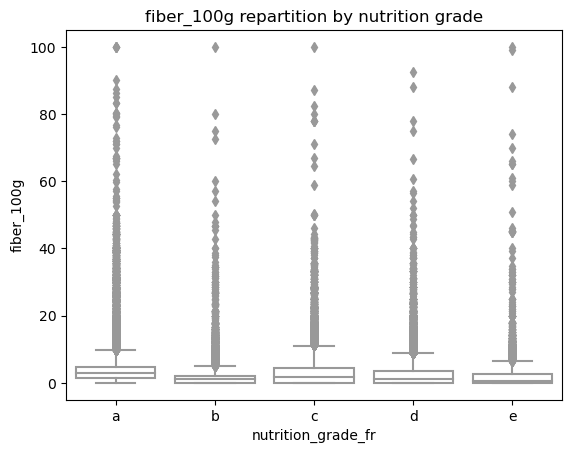

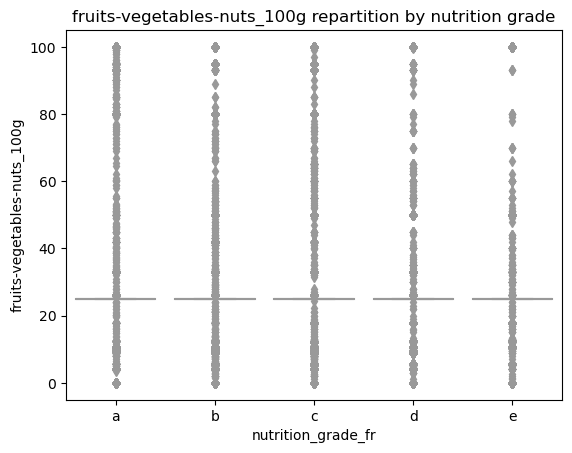

In [233]:
for col in components_100g:
    ax = sns.boxplot(x="nutrition_grade_fr", y=col, 
                     data=completed_data, color='white', 
                     order=['a', 'b', 'c', 'd', 'e'])
    plt.xlabel('nutrition_grade_fr')
    plt.ylabel(col)
    plt.title(f'{col} repartition by nutrition grade')
    plt.show()

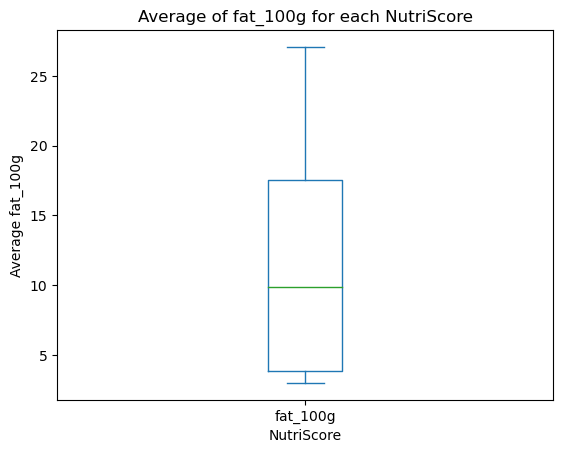

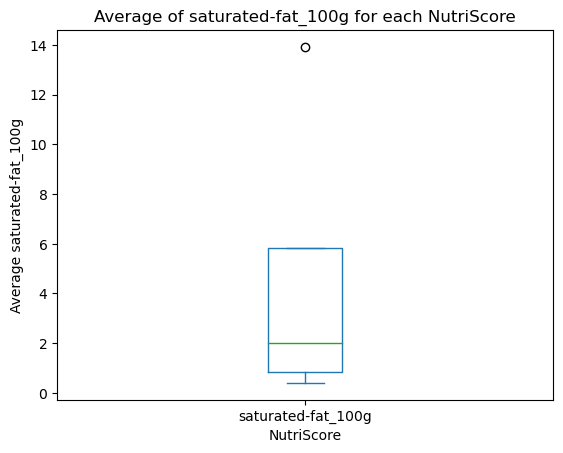

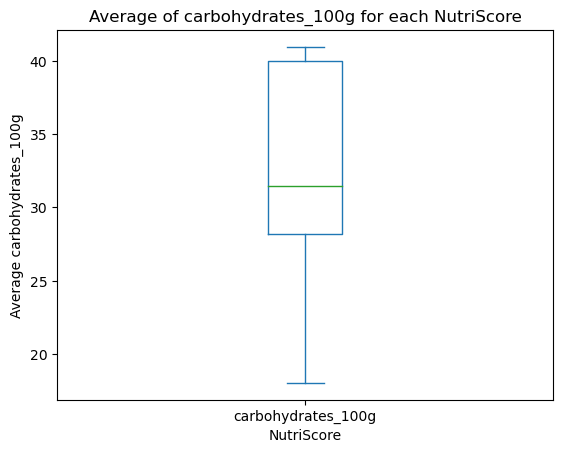

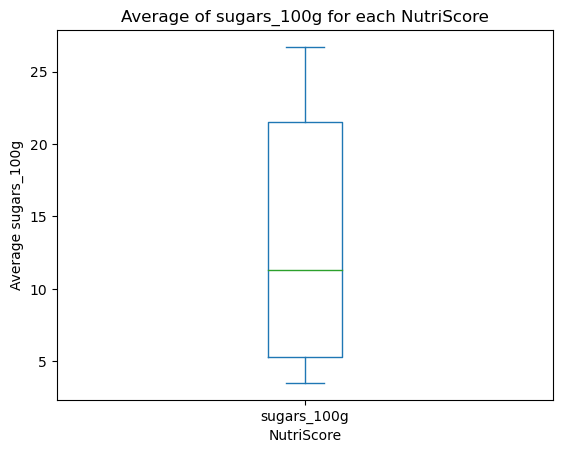

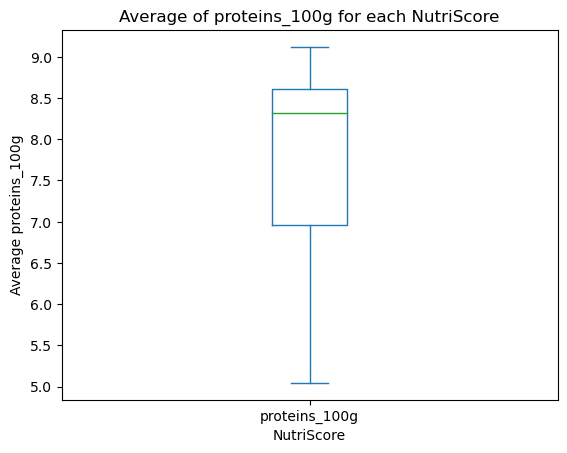

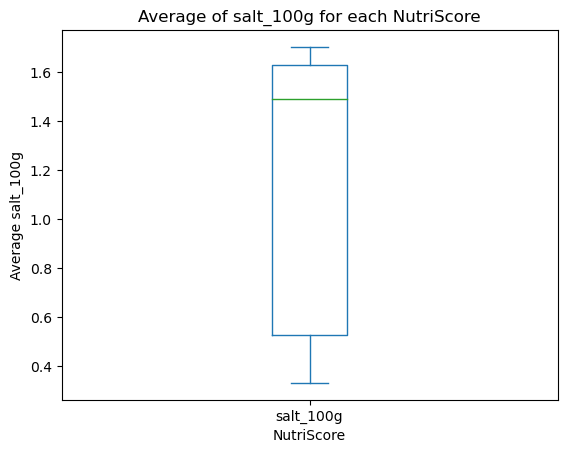

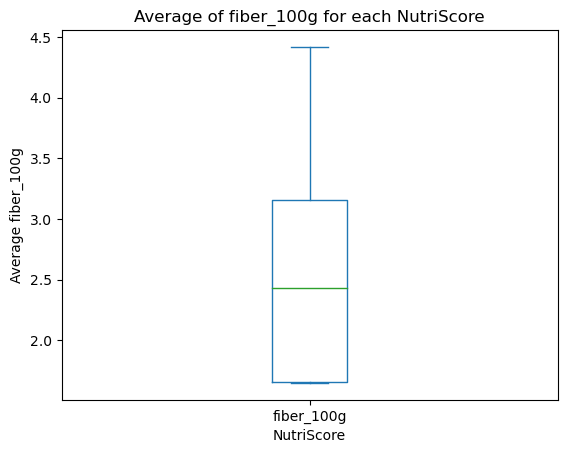

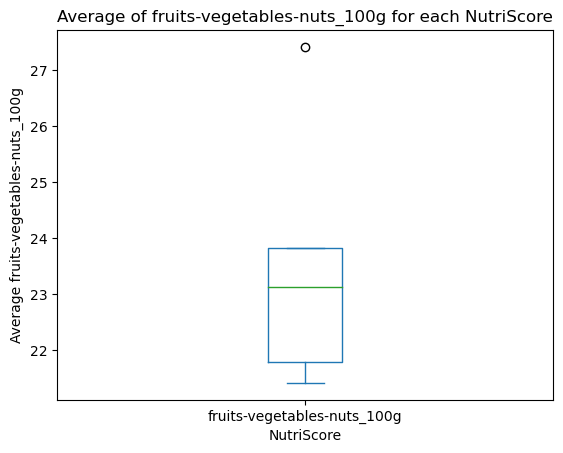

In [232]:
# box plotting to examine outliers detection
for col in components_100g:
    grouped_data[col].mean().plot(kind='box')
    plt.title(f'Average of {col} for each NutriScore')
    plt.xlabel('NutriScore')
    plt.ylabel(f'Average {col}')
    plt.show()

### Multi-variate analysis

#### PCA

In [201]:
numerical = completed_data.select_dtypes(include=['float64', 'int64']).columns
X = completed_data[numerical].values
X[:5]

array([[2.24300e+03, 2.85700e+01, 2.85700e+01, 6.42900e+01, 1.42900e+01,
        3.60000e+00, 3.57000e+00, 0.00000e+00, 2.50000e+01, 1.40000e+01],
       [1.94100e+03, 1.78600e+01, 0.00000e+00, 6.07100e+01, 1.78600e+01,
        7.10000e+00, 1.78600e+01, 6.35000e-01, 2.50000e+01, 0.00000e+00],
       [2.54000e+03, 5.71400e+01, 5.36000e+00, 1.78600e+01, 3.57000e+00,
        7.10000e+00, 1.78600e+01, 1.22428e+00, 2.50000e+01, 1.20000e+01],
       [1.83300e+03, 1.87500e+01, 4.69000e+00, 5.78100e+01, 1.56200e+01,
        9.40000e+00, 1.40600e+01, 1.39700e-01, 2.50000e+01, 7.00000e+00],
       [2.23000e+03, 3.66700e+01, 5.00000e+00, 3.66700e+01, 3.33000e+00,
        6.70000e+00, 1.66700e+01, 1.60782e+00, 2.50000e+01, 1.20000e+01]])

In [202]:
X.shape

(221210, 10)

In [203]:
# We will use the "code" feature as index
completed_data.set_index("code")
codes = completed_data.index

In [204]:
# Storing columns
features = completed_data.columns

In [205]:
scaler = StandardScaler()
scaler.fit(X)

StandardScaler()

In [206]:
X_scaled = scaler.transform(X)

In [207]:
idx = ["mean", "std"]

pd.DataFrame(X_scaled).describe().round(2).loc[idx]

0    1    2    3    4    5    6    7    8    9
mean -0.0 -0.0  0.0  0.0 -0.0 -0.0 -0.0  0.0 -0.0  0.0
std   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [208]:
#Instance
pca= PCA()

In [209]:
pca.fit(X_scaled)

PCA()

### Ebouli des valeurs

In [210]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([32.51, 18.64, 13.25, 10.38,  9.49,  6.68,  4.14,  2.82,  1.87,
        0.21])

In [211]:
scree_cum = scree.cumsum()
scree_cum

array([32.51, 51.15, 64.4 , 74.78, 84.27, 90.95, 95.09, 97.91, 99.78,
       99.99])

In [212]:
x_list = range(1, len(numerical)+1)
list(x_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

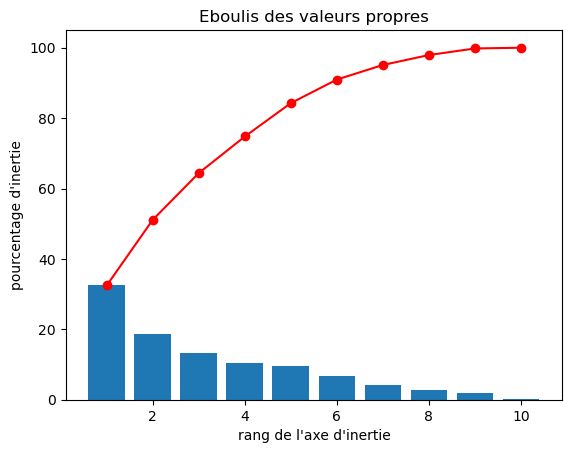

In [213]:
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show()

The first two features explain 50% of variance, and the first four almost 80%

In [214]:
pcs = pd.DataFrame(pca.components_)
pcs

0         1         2         3         4         5         6  \
0  0.513023  0.444725  0.417877  0.233674  0.242877  0.095348  0.139784   
1 -0.024762  0.300381  0.237528 -0.564030 -0.574900 -0.025647  0.406785   
2  0.189437 -0.015030 -0.215816  0.246903 -0.125701  0.756786  0.386199   
3 -0.015465 -0.178137 -0.170756  0.169225  0.025264  0.045580  0.120155   
4  0.011922  0.079776  0.039259 -0.083597  0.006734  0.054130  0.021303   
5  0.014760  0.267639  0.175007 -0.110275 -0.172844  0.422644 -0.778824   
6 -0.447421 -0.343930  0.480485 -0.277916  0.371609  0.418282  0.123003   
7  0.041127 -0.354575  0.626371  0.479461 -0.381674 -0.169109 -0.000361   
8  0.080444  0.240203  0.194549 -0.131241  0.528067 -0.173689  0.130866   
9 -0.700971  0.548022 -0.000372  0.440653 -0.038974 -0.012814  0.110103   

          7         8         9  
0 -0.000028 -0.102027  0.460187  
1  0.117210 -0.150393 -0.040135  
2 -0.111483  0.066287 -0.319141  
3  0.846023 -0.406715  0.109124  
4  0.446764  0.879656  0.090227  
5  0.171124 -0.118666 -0.164097  
6 -0.028904 -0.048517  0.205064  
7  0.043635  0.067451 -0.263885  
8  0.162643 -0.048782 -0.725105  
9 -0.002079 -0.000682  0.018055

In [215]:
pcs.columns = numerical
pcs.index = [f"F{i}" for i in x_list]
pcs

energy_100g  fat_100g  saturated-fat_100g  carbohydrates_100g  \
F1      0.513023  0.444725            0.417877            0.233674   
F2     -0.024762  0.300381            0.237528           -0.564030   
F3      0.189437 -0.015030           -0.215816            0.246903   
F4     -0.015465 -0.178137           -0.170756            0.169225   
F5      0.011922  0.079776            0.039259           -0.083597   
F6      0.014760  0.267639            0.175007           -0.110275   
F7     -0.447421 -0.343930            0.480485           -0.277916   
F8      0.041127 -0.354575            0.626371            0.479461   
F9      0.080444  0.240203            0.194549           -0.131241   
F10    -0.700971  0.548022           -0.000372            0.440653   

     sugars_100g  fiber_100g  proteins_100g  salt_100g  \
F1      0.242877    0.095348       0.139784  -0.000028   
F2     -0.574900   -0.025647       0.406785   0.117210   
F3     -0.125701    0.756786       0.386199  -0.111483   
F4      0.025264    0.045580       0.120155   0.846023   
F5      0.006734    0.054130       0.021303   0.446764   
F6     -0.172844    0.422644      -0.778824   0.171124   
F7      0.371609    0.418282       0.123003  -0.028904   
F8     -0.381674   -0.169109      -0.000361   0.043635   
F9      0.528067   -0.173689       0.130866   0.162643   
F10    -0.038974   -0.012814       0.110103  -0.002079   

     fruits-vegetables-nuts_100g  nutrition-score-fr_100g  
F1                     -0.102027                 0.460187  
F2                     -0.150393                -0.040135  
F3                      0.066287                -0.319141  
F4                     -0.406715                 0.109124  
F5                      0.879656                 0.090227  
F6                     -0.118666                -0.164097  
F7                     -0.048517                 0.205064  
F8                      0.067451                -0.263885  
F9                     -0.048782                -0.725105  
F10                    -0.000682                 0.018055

#### Correlation circle

In [216]:
x, y = 0,1

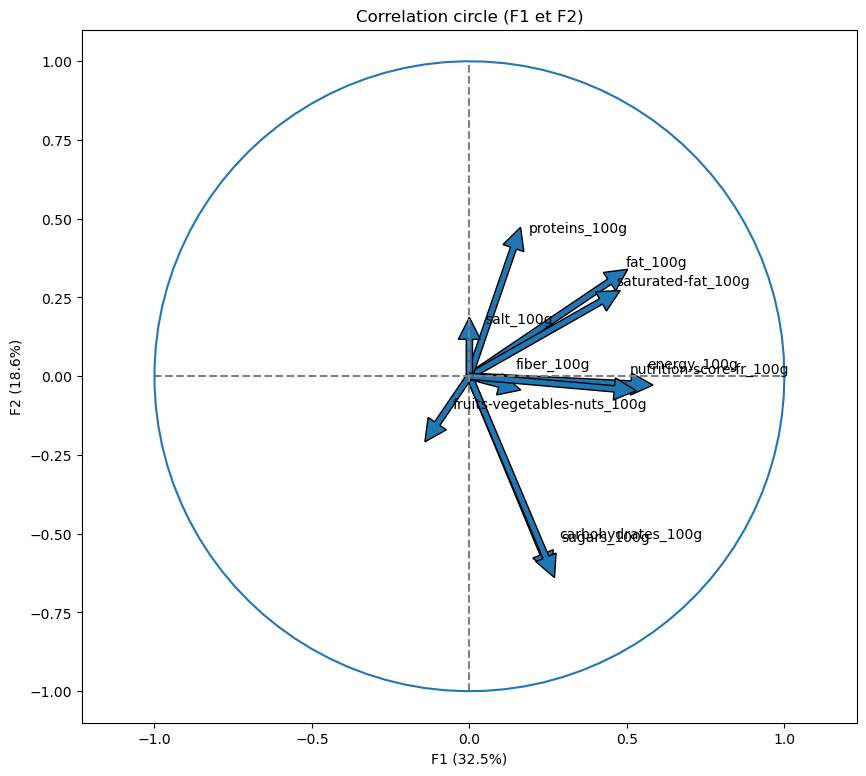

In [217]:
fig, ax = plt.subplots(figsize=(10, 9))
for i in range(0, pca.components_.shape[1]):
    ax.arrow(0,
             0,  # Start the arrow at the origin
             pca.components_[0, i],  #0 for PC1
             pca.components_[1, i],  #1 for PC2
             head_width=0.07,
             head_length=0.07, 
             width=0.02,              )

    plt.text(pca.components_[0, i] + 0.05,
             pca.components_[1, i] + 0.05,
             numerical[i])
    
# affichage des lignes horizontales et verticales
plt.plot([-1, 1], [0, 0], color='grey', ls='--')
plt.plot([0, 0], [-1, 1], color='grey', ls='--')


# nom des axes, avec le pourcentage d'inertie expliqué
plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

plt.title("Correlation circle (F{} et F{})".format(x+1, y+1))


an = np.linspace(0, 2 * np.pi, 100)
plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
plt.axis('equal')
plt.show(block=False)

In [218]:
# function
def correl_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[x, i],  
                pca.components_[y, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                numerical[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Correlation circle (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

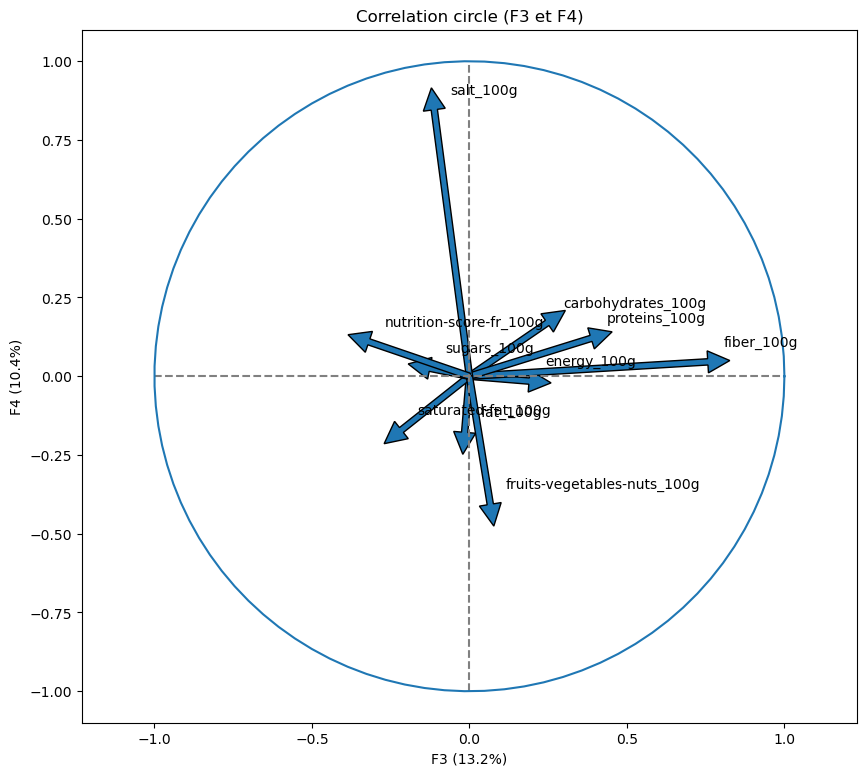

In [219]:
correl_graph(pca,(2,3), numerical)

### ANOVA

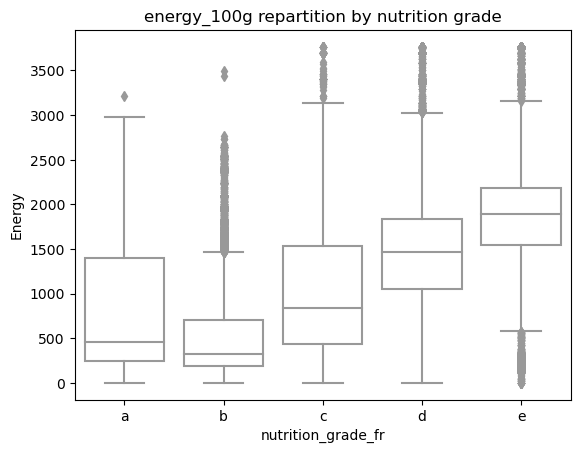

In [227]:
#How is energy_100g related to nutrition grade

ax = sns.boxplot(x="nutrition_grade_fr", y="energy_100g", 
                 data=completed_data, color='white', 
                 order=['a', 'b', 'c', 'd', 'e'])
plt.xlabel('nutrition_grade_fr')
plt.ylabel('Energy')
plt.title('energy_100g repartition by nutrition grade')
plt.show()

As expected, we can see that grade "a" has a lower mean that "c", "d" or "e". \
"b" being under-represented and with a lot of outlier, we expect this slight deviation.

##### test anova

After experimentation, we decided to try out what it would be to evaluate WIHTOUT nutriscore, \
which means evaluate our completion regarding nutriscore

In [235]:
#Let's smooth out the columns names first to avoid errors

def rename_columns(df):
    """
    Rename columns in the DataFrame to replace hyphens with underscores.
    
    :param df: pandas DataFrame
    :return: DataFrame with updated column names
    """
    df = df.rename(columns=lambda x: x.replace('-', '_'))
    return df

# Assuming your DataFrame is named 'completed_data'
completed_data_rename = rename_columns(completed_data)

In [236]:
#changing nutrition grade to numerical values to enable ANOVA
completed_data_rename["nutrition_grade_fr"] = completed_data_rename["nutrition_grade_fr"].replace({"a": 1, 
                                                                                    "b": 2,
                                                                                    "c": 3,
                                                                                    "d": 4,
                                                                                    "e": 5})

In [237]:
#new variable with the new name
numerical_rename = completed_data_rename.select_dtypes(include=['float64', 'int64']).columns
numerical_rename

Index(['nutrition_grade_fr', 'energy_100g', 'fat_100g', 'saturated_fat_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'salt_100g', 'fruits_vegetables_nuts_100g', 'nutrition_score_fr_100g'],
      dtype='object')

In [251]:
numerical_rename2 = [col for col in numerical_rename if col not in ['nutrition_score_fr_100g', "nutrition_grade_fr"]]
numerical_rename2

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'fruits_vegetables_nuts_100g']

In [252]:
column_names2 = completed_data_rename[numerical_rename2].columns
formula2 = 'nutrition_grade_fr ~ ' + ' + '.join(column_names2)
formula2

'nutrition_grade_fr ~ energy_100g + fat_100g + saturated_fat_100g + carbohydrates_100g + sugars_100g + fiber_100g + proteins_100g + salt_100g + fruits_vegetables_nuts_100g'

In [253]:
anova_energy2 = smf.ols(formula2, data=completed_data_rename).fit()
print(anova_energy2.summary())

                            OLS Regression Results                            
Dep. Variable:     nutrition_grade_fr   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                 3.678e+04
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:51:34   Log-Likelihood:            -2.7909e+05
No. Observations:              221210   AIC:                         5.582e+05
Df Residuals:                  221200   BIC:                         5.583e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [267]:
sm.stats.anova_lm(anova_energy2, typ=2)

sum_sq        df             F  \
energy_100g                    1400.646392       1.0   1918.299302   
fat_100g                        485.390800       1.0    664.782231   
saturated_fat_100g            13395.301230       1.0  18345.955941   
carbohydrates_100g              300.863493       1.0    412.057056   
sugars_100g                   31208.546909       1.0  42742.646601   
fiber_100g                    17212.329632       1.0  23573.687195   
proteins_100g                   900.338849       1.0   1233.087377   
salt_100g                      9621.172785       1.0  13176.979673   
fruits_vegetables_nuts_100g     531.237217       1.0    727.572632   
Residual                     161509.198077  221200.0           NaN   

                                    PR(>F)  
energy_100g                   0.000000e+00  
fat_100g                     2.246255e-146  
saturated_fat_100g            0.000000e+00  
carbohydrates_100g            1.584898e-91  
sugars_100g                   0.000000e+00  
fiber_100g                    0.000000e+00  
proteins_100g                2.184428e-269  
salt_100g                     0.000000e+00  
fruits_vegetables_nuts_100g  5.495322e-160  
Residual                               NaN

In [262]:
# remove nutrigrade from numerical
numerical_rename2 = [col for col in numerical_rename if col not in ["nutrition_grade_fr"]]
numerical_rename2

['energy_100g',
 'fat_100g',
 'saturated_fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'fiber_100g',
 'proteins_100g',
 'salt_100g',
 'fruits_vegetables_nuts_100g',
 'nutrition_score_fr_100g']

In [264]:
column_names3 = completed_data_rename[numerical_rename2].columns
formula = 'nutrition_grade_fr ~ ' + ' + '.join(column_names3)
formula

'nutrition_grade_fr ~ energy_100g + fat_100g + saturated_fat_100g + carbohydrates_100g + sugars_100g + fiber_100g + proteins_100g + salt_100g + fruits_vegetables_nuts_100g + nutrition_score_fr_100g'

In [265]:
anova_energy3 = smf.ols(formula, data=completed_data_rename).fit()
print(anova_energy3.summary())

                            OLS Regression Results                            
Dep. Variable:     nutrition_grade_fr   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.530e+05
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:54:02   Log-Likelihood:            -1.0147e+05
No. Observations:              221210   AIC:                         2.030e+05
Df Residuals:                  221199   BIC:                         2.031e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [266]:
sm.stats.anova_lm(anova_energy3, typ=2)

sum_sq        df              F  \
energy_100g                      76.816868       1.0     524.183479   
fat_100g                         33.802397       1.0     230.661030   
saturated_fat_100g              738.489727       1.0    5039.311363   
carbohydrates_100g                3.098937       1.0      21.146547   
sugars_100g                     184.759713       1.0    1260.764624   
fiber_100g                       13.440679       1.0      91.716602   
proteins_100g                    10.745288       1.0      73.323769   
salt_100g                       160.575289       1.0    1095.734776   
fruits_vegetables_nuts_100g      20.393796       1.0     139.163327   
nutrition_score_fr_100g      129093.421904       1.0  880908.594621   
Residual                      32415.776173  221199.0            NaN   

                                    PR(>F)  
energy_100g                  7.104706e-116  
fat_100g                      4.544714e-52  
saturated_fat_100g            0.000000e+00  
carbohydrates_100g            4.257023e-06  
sugars_100g                  2.281430e-275  
fiber_100g                    1.009982e-21  
proteins_100g                 1.107236e-17  
salt_100g                    1.082338e-239  
fruits_vegetables_nuts_100g   4.147788e-32  
nutrition_score_fr_100g       0.000000e+00  
Residual                               NaN

##### real anova

In [254]:
#changing nutrition grade to numerical values to enable ANOVA
completed_data["nutrition_grade_fr"] = completed_data["nutrition_grade_fr"].replace({"a": 1, 
                                                                                    "b": 2,
                                                                                    "c": 3,
                                                                                    "d": 4,
                                                                                    "e": 5})

In [255]:
anova_energy = smf.ols('nutrition_grade_fr~completed_data[numerical]', data=completed_data).fit()
print(anova_energy.summary())

                            OLS Regression Results                            
Dep. Variable:     nutrition_grade_fr   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                 2.530e+05
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        15:52:04   Log-Likelihood:            -1.0147e+05
No. Observations:              221210   AIC:                         2.030e+05
Df Residuals:                  221199   BIC:                         2.031e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [256]:
sm.stats.anova_lm(anova_energy, typ=2)

sum_sq        df             F  PR(>F)
completed_data[numerical]  370768.697133      10.0  253005.40268     0.0
Residual                    32415.776173  221199.0           NaN     NaN

Nutrition grade is dependent of our numerical values, hence that we can use our components to predict the nutri score.

### Conclusion

- The "fruits-veg-nut" feature, seen as important with domain-related research, is too incomplete in this dataset
- Imputations result in some perturbations in data analysis
- Another imputation approach than IterativeImputer could be tested, k-means for example \

Despite those reservations, dataset is usable to build an application of suggestion or auto-completion. \
Indeed, cleaned and completed data are coherent and produced results also.


### FUN TIME
ML testing

In [270]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [ ]:
#that's done already for ANOVA
"""#changing nutrition grade to numerical values
completed_data["nutrition_grade_fr"] = completed_data["nutrition_grade_fr"].replace({"a": 1, 
                                                                                    "b": 2,
                                                                                    "c": 3,
                                                                                    "d": 4,
                                                                                    "e": 5})"""

In [268]:
X = completed_data[numerical2]
Y = completed_data["nutrition_grade_fr"]

In [271]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, 
                                                            test_size = 0.25, 
                                                            random_state=42)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(165907, 10) (55303, 10) (165907,) (55303,)


In [272]:
lmodellineaire = LinearRegression()
lmodellineaire.fit(X_train, Y_train)

LinearRegression()

In [273]:
Y_train_predict = lmodellineaire.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train, Y_train_predict)))
r2 = r2_score(Y_train, Y_train_predict)
print('Performance du modele \n---------------------------')
print(f"L'erreur quadratique moyenne est {rmse}")
print(f'Le score r2 est {r2}')

Performance du modele 
---------------------------
L'erreur quadratique moyenne est 0.3828270603106442
Le score r2 est 0.9195338697259684


In [ ]:
#test 
#chosing one of the last 5 - "tartines craquantes bio au sarrasin"
completed_data.tail(5)

In [ ]:
chosen = "9787461062105" #code is a string type wtf ???
that = completed_data[completed_data["code"]==chosen]
that

In [ ]:
#copying the details of the chosen individual

test_array = that[numerical].to_numpy()
#establising a df to use our model on, containing only our individual
df = pd.DataFrame(test_array, columns=numerical)

#define expectations
expected  = that["nutrition_grade_fr"].values[0]
print(f"Exepected result is {expected}")

#using the model .predict to obtain the numerical nutri_grade
lmodellineaire.predict(df)


Fun, but the result is a float, which is not possible really.
Maybe a decision would be better

In [ ]:
#init
nutri_tree = tree.DecisionTreeClassifier()

In [ ]:
#cutting into categories
Y_train_tree = pd.cut(Y_train, bins= [0,1,2,3,4,5], labels = ["a", "b", "c", "d", "e"])
Y_train_tree.value_counts()

In [ ]:
nutri_tree.fit(X_train, Y_train_tree)

In [ ]:
tree.plot_tree(nutri_tree, filled=True, feature_names=X_train.columns);

In [ ]:
Y_test_tree = pd.cut(Y_test, bins= [0,1,2,3,4,5], labels = ["a", "b", "c", "d", "e"])
Y_predict = nutri_tree.predict(X_test)
accuracy = nutri_tree.score(X_test, Y_test_tree)
accuracy

Sounds too good to be true. Would a random forest be more realistic ? \
Could those results be explained by the fact that a lot of data were imputed ?